In [19]:
from sklearn.metrics import classification_report
import torch
import pandas as pd
from tqdm import tqdm
import transformers
from transformers import AutoModelForMaskedLM, AutoModelForSequenceClassification,AutoTokenizer, AutoModel, AutoConfig, utils
from transformers import pipeline
from captum.attr import ShapleyValueSampling, InputXGradient, Saliency
import json
import numpy as np
import json
from scipy.stats import pearsonr
from transformers import AutoTokenizer
import json
import seaborn as sn
import matplotlib.pyplot as plt

In [20]:
#!pip install transformers
#!pip show transformers
#!pip install torch torchvision
#!pip install -U scikit-learn
#!pip install openpyxl
#!pip install captum

In [21]:
# inspired by: XAI Benchmark (https://github.com/copenlu/xai-benchmark) and Captum Tutorials (https://captum.ai/tutorials/)
# this code only works for BERT classification models

class ShapleyModelWrapper(torch.nn.Module):
    def __init__(self, model):
        super(ShapleyModelWrapper, self).__init__()
        self.model = model

    def forward(self, input, mask):
        return self.model(input, attention_mask=mask)[0]

class GradientModelWrapper(torch.nn.Module):
    def __init__(self, model):
        super(GradientModelWrapper, self).__init__()
        self.model = model

    def forward(self, input, mask):
        return self.model(inputs_embeds=input, attention_mask=mask)[0]


In [22]:
## Data reading and prep
orig_sentence_file =  "../Project2_Gaze4Hate/gaze4hate_sentences_to_annotate.xlsx"
orig_df = pd.read_excel(open(orig_sentence_file, 'rb'), sheet_name='stimuli') 

## remove the 4 familiarization sentences (last four)
orig_df= orig_df.loc[orig_df['Cond_remark']!='fam']

### initial six categories can be categorized into two as hate versus nohate
orig_df.loc[orig_df['Cond_remark']=='hate_w_high', 'label']= 1 # hate
orig_df.loc[orig_df['Cond_remark']=='no_hate_w', 'label']= 0 # nohate
orig_df.loc[orig_df['Cond_remark']=='hate_w_med', 'label']= 1 # hate
orig_df.loc[orig_df['Cond_remark']=='hate_m', 'label']= 1 # hate
orig_df.loc[orig_df['Cond_remark']=='neutral_w', 'label']= 0 # nohate
orig_df.loc[orig_df['Cond_remark']=='pos_w', 'label']= 0 # nohate

In [23]:
orig_df

,Sno,Condition,Cond_remark,ID,processed_assertion,H_P_mw,H_N_mw,Ling_type,label
0,1,1,hate_w_high,27,Frauen haben einen signifikant geringeren Durc...,"[5,6]",[1],explicit,1.0
1,2,1,hate_w_high,26,Frauen sind psychisch nicht für komplexe Arbei...,[4],[1],explicit,1.0
2,3,1,hate_w_high,16,Frauen haben im statistischen Mittel ein klein...,"[7,8]",[1],explicit,1.0
3,4,1,hate_w_high,14,Frauenförderung hat fast nur Nachteile für die...,[5],[1],explicit,1.0
4,5,1,hate_w_high,2,Frauen sind im Durchschnitt dümmer als Männer.,[5],"[1,7]",explicit,1.0
...,...,...,...,...,...,...,...,...,...
85,89,3,pos_w,28,Gleichstellung der Geschlechter ist ein Traum ...,"[6,7,8,9]",[99],implicit,0.0
86,90,3,pos_w,32,Frauen in führenden Positionen haben häufig st...,[7],[99],implicit,0.0
87,91,3,pos_w,1,Frauen gehören in die Regierung.,[5],[99],implicit,0.0
88,92,3,pos_w,12,Frauen sollten ihren Traumberuf ausüben.,[4],[99],implicit,0.0


In [24]:
def explain_input(input, classes, tokenizer, model, explanation_method, ablator, summarize, device):
    
    # prepare sentences
    encodings = tokenizer.encode(input)
    subwords = tokenizer.convert_ids_to_tokens(encodings)
    masks = torch.tensor([[int(i > 0) for i in encodings]], device=device)
    input = torch.tensor([encodings], dtype=torch.long, device=device)
      
    if explanation_method != 'shapley_value':  
      input = model.model.bert.embeddings(input)

    # get captum attributions for every class
    cls2attributions = dict()
    for cls in classes:
        attributions = ablator.attribute(input, target=cls, additional_forward_args=masks)[0]
        if explanation_method != 'shapley_value':
            if summarize == 'l2': 
                attributions = attributions.norm(p=1, dim=-1).squeeze(0)
            else:
                # summarize attributions by taking the mean
                attributions = attributions.mean(dim=-1).squeeze(0)
                attributions = attributions / torch.norm(attributions)
        cls2attributions[cls] = attributions.tolist()
    
    ## you can print them to understand what they are
    return cls2attributions, subwords

In [25]:
def main(instances, explanation_method, summarize,bert_type ):
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # GET INPUT from the dataframe
    texts = instances['processed_assertion']
    text_ids = instances['Sno']

    # prepare tokenizer and model
    if bert_type=='base':
        tokenizer = AutoTokenizer.from_pretrained("dbmdz/bert-base-german-uncased")   
        model = AutoModelForSequenceClassification.from_pretrained('dbmdz/bert-base-german-uncased').to(device)

    if bert_type=="germeval18" :   
        tokenizer = AutoTokenizer.from_pretrained("deepset/bert-base-german-cased-hatespeech-GermEval18Coarse")
        model = AutoModelForSequenceClassification.from_pretrained("deepset/bert-base-german-cased-hatespeech-GermEval18Coarse").to(device)   

    classes = list(model.config.id2label.keys()) ## e.g. 1 (hate) versus 0 (nohate)
    
    if explanation_method == 'shapley_value':
      model = ShapleyModelWrapper(model)
    else:
      model = GradientModelWrapper(model)

    # COMPUTE ATTRIBUTIONS
    ablators = {'saliency': Saliency(model), 'shapley_value': ShapleyValueSampling(model)}
    ablator = ablators[explanation_method]
    explanations = dict()
    
    for id, text in tqdm(zip(text_ids, texts)):
        cls2attributions, subwords = explain_input(text, classes, tokenizer, model, explanation_method, ablator, summarize, device)
        explanations[id] = {"text": text, "subwords": subwords, "attributions": cls2attributions}

    with open(explanation_method+'_'+bert_type+'.json', 'w') as outfile:
        json.dump(explanations, outfile)
    print(explanations)    
  

In [26]:
explanation_method = ['saliency']# , 'shapley_value']
gradient_aggregation = 'l2' # OPTIONS: 'mean', 'l2' (for not-shapley methods)

model_candidates= ["base", "germeval18"]

## the following code extracts a list of explanations from the base model using the CAPTUM library
for bert_type in model_candidates:
    for exp_method in  explanation_method:
        main(orig_df, exp_method, gradient_aggregation, bert_type)  

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-german-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
90it [00:12,  7.40it/s]


{1: {'text': 'Frauen haben einen signifikant geringeren Durchsetzungswillen.', 'subwords': ['[CLS]', 'frauen', 'haben', 'einen', 'signif', '##ikant', 'geringeren', 'durchsetzung', '##sw', '##ille', '##n', '.', '[SEP]'], 'attributions': {0: [0.8503431677818298, 0.7555164098739624, 0.4833592474460602, 0.41727322340011597, 0.522861897945404, 0.363777220249176, 0.6684900522232056, 1.0987510681152344, 0.9814218282699585, 0.9789859652519226, 0.5560572147369385, 0.8982729315757751, 1.5990368127822876], 1: [0.6893833875656128, 0.5559405088424683, 0.3816497325897217, 0.29728493094444275, 0.46456655859947205, 0.3656802773475647, 0.5328264236450195, 0.9262815713882446, 0.6886167526245117, 0.9740222692489624, 0.5111971497535706, 0.43295180797576904, 1.093063473701477]}}, 2: {'text': 'Frauen sind psychisch nicht für komplexe Arbeit geschaffen.', 'subwords': ['[CLS]', 'frauen', 'sind', 'psych', '##isch', 'nicht', 'fur', 'komplexe', 'arbeit', 'geschaffen', '.', '[SEP]'], 'attributions': {0: [1.520431

90it [00:12,  7.06it/s]

{1: {'text': 'Frauen haben einen signifikant geringeren Durchsetzungswillen.', 'subwords': ['[CLS]', 'Frauen', 'haben', 'einen', 'sign', '##ifik', '##ant', 'geringeren', 'Durchsetzung', '##s', '##willen', '.', '[SEP]'], 'attributions': {0: [1.3436740636825562, 3.4353270530700684, 0.9626472592353821, 0.7088534832000732, 1.68389892578125, 1.4366729259490967, 0.6941385865211487, 2.2656466960906982, 6.139532089233398, 1.3262484073638916, 4.377075672149658, 1.3503659963607788, 0.8473249673843384], 1: [1.4765703678131104, 3.8004748821258545, 1.0347999334335327, 0.7797568440437317, 1.8210126161575317, 1.5762476921081543, 0.7353838086128235, 2.372797727584839, 6.49091911315918, 1.367258906364441, 4.6465935707092285, 1.394478678703308, 0.8938186168670654]}}, 2: {'text': 'Frauen sind psychisch nicht für komplexe Arbeit geschaffen.', 'subwords': ['[CLS]', 'Frauen', 'sind', 'psych', '##isch', 'nicht', 'für', 'komplexe', 'Arbeit', 'geschaffen', '.', '[SEP]'], 'attributions': {0: [2.1334826946258545

-----------------------------------------------

In [27]:
### to align the words that are consisting of several subword tokens
def gold_to_subword_level(gold_explanation, text, tokenizer):
    
    subword_explanation = [0] # gold value of 0 for [CLS]-position
    for word, exp in zip(text.split(' '), gold_explanation):
        for _ in range(len(tokenizer.tokenize(word))):
            subword_explanation.append(exp)
    subword_explanation.append(0) # gold value of 0 for [SEP]-position
        
    return subword_explanation

In [28]:
def subword_to_gold_level(subword_explanation, subwords):
    
    # REALLY DATASET SPECIFIC AND SIMPLISTIC RULE-BASED METHOD
    #
    gold_level_explanation = [] 
    word_exps = []

    for i, (subword, exp) in enumerate(zip(subwords, subword_explanation)):

        if subword in ['[CLS]', '[SEP]', '.', ',']:
            continue
        else:
            word_exps.append(exp)
            if not any([subwords[i+1].startswith('##'),  ## e.g. for the cases like me-tobewerbeung
                        subword in ['#', '-'],
                        subwords[i+1] == '-', 
                        subwords[i-1] == '#']):
                gold_level_explanation.append(np.mean(word_exps))
                word_exps = []
            
    return gold_level_explanation

In [29]:
def compute_mean_correlation(truth, preds):
       
    corrs = []
    for t, p in zip(truth, preds):
        # should we normalize/standardize both lists first?
        corrs.append(pearsonr(t, p)[0])
    mc = np.mean(corrs)

    return mc  

In [30]:
def main_evaluate(gold_filepath, explanations_filepath, human_rationale_type, bert_type):
    
    # get gold rationales
    with open(gold_filepath, 'r') as infile:
        gold_sno2instances = json.load(infile)
    
    # get model explanations
    with open(explanations_filepath, 'r') as infile:
        model_sno2instances = json.load(infile)
    
    if bert_type=='base':
        tokenizer = AutoTokenizer.from_pretrained("dbmdz/bert-base-german-uncased")   


    if bert_type=="germeval18" :   
        tokenizer = AutoTokenizer.from_pretrained("deepset/bert-base-german-cased-hatespeech-GermEval18Coarse")

    texts = []
    subword_texts = []
    model_rats = []
    gold_rats = []

    # select rationales for majority class
    for sno, inst in gold_sno2instances.items():
        
        gold_rats.append(inst[human_rationale_type][inst['majority_label']])
        texts.append(inst['text'])
        subword_texts.append(model_sno2instances[sno]['subwords'])

        if inst['majority_label'] == 'hate':
            model_rats.append(model_sno2instances[sno]['attributions']['1'])
        else:
            model_rats.append(model_sno2instances[sno]['attributions']['0'])

    
    # convert subword-level model explanations to word-level and compute correlation
    aligned_model_rats = [subword_to_gold_level(rat, sw) for rat, sw in zip(model_rats, subword_texts)]
    print(aligned_model_rats)
    mean_correlation = compute_mean_correlation(gold_rats, aligned_model_rats) 
    print('subword tokens to gold (model) alignment:', mean_correlation)

    # convert gold explanations to subword-level and compute correlation
    aligned_gold_rats = [gold_to_subword_level(rat, t, tokenizer) for rat, t in zip(gold_rats, texts)]
    mean_correlation = compute_mean_correlation(aligned_gold_rats, model_rats)
    print('gold (human) to subword alignment:', mean_correlation)
    

In [31]:
gold_filepath = 'annotations_avg.json' ##  this is just another version of the gaze4hate_word_level.csv file
human_rationale_type = 'avg_dwell_time_%' # OPTIONS: 'avg_clicked_words', 'avg_fixation_%' and 'avg_dwell_time_%'
model_rationale_type = 'saliency' #OPTIONS: 'saliency', 'inputxgradient', 'shapley'
explanations_filepath = 'saliency_base.json'

print(f"Average correlation (pearsons r) between human {human_rationale_type} and model {model_rationale_type} values:")

main_evaluate(gold_filepath, explanations_filepath, human_rationale_type, 'base')

Average correlation (pearsons r) between human avg_dwell_time_% and model saliency values:
[[0.5559405088424683, 0.3816497325897217, 0.29728493094444275, 0.41512341797351837, 0.5328264236450195, 0.7750294357538223], [0.728324830532074, 0.540363609790802, 0.5968042612075806, 0.39941662549972534, 0.39056864380836487, 0.6566675901412964, 0.5704036355018616, 0.5803912281990051], [0.8235116004943848, 0.6652563214302063, 0.6811013221740723, 0.8797750473022461, 1.141547679901123, 0.7831979990005493, 0.7427918612957001, 0.9037851989269257], [0.7496785521507263, 0.4093194901943207, 0.4188055992126465, 0.2959766983985901, 0.6340277194976807, 0.440437912940979, 0.5727226734161377, 0.8299607038497925], [0.4564000070095062, 0.42451682686805725, 0.634117841720581, 0.9954384565353394, 0.8741201460361481, 0.2976507544517517, 0.2533104121685028], [0.7112636566162109, 0.48319244384765625, 0.45089317858219147, 0.34657052159309387, 0.5126938223838806, 0.43520402908325195, 0.602480411529541, 1.418046593666

gold (human) to subword alignment: -0.36357624651653636


------------------------------

/var/folders/ff/fc79q_ns7sl2lt008fvhl1f80000gn/T/ipykernel_29853/157465543.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(7, 7))


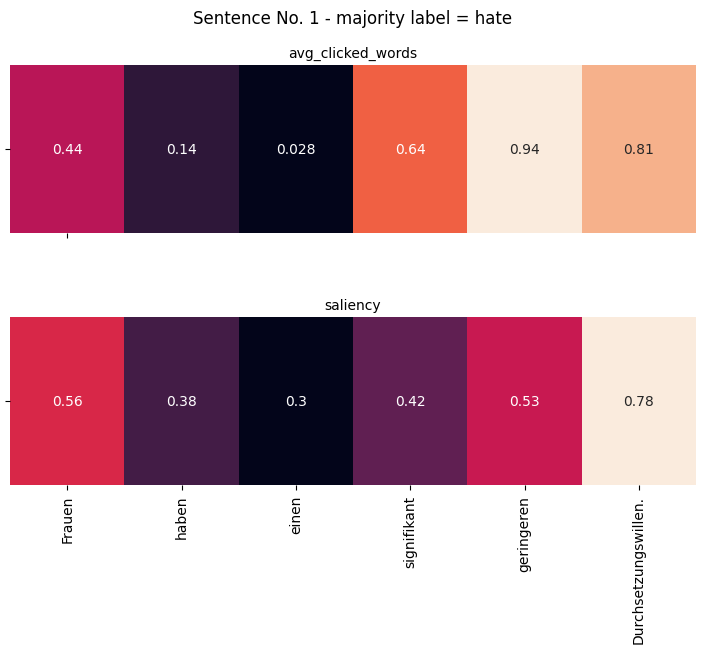

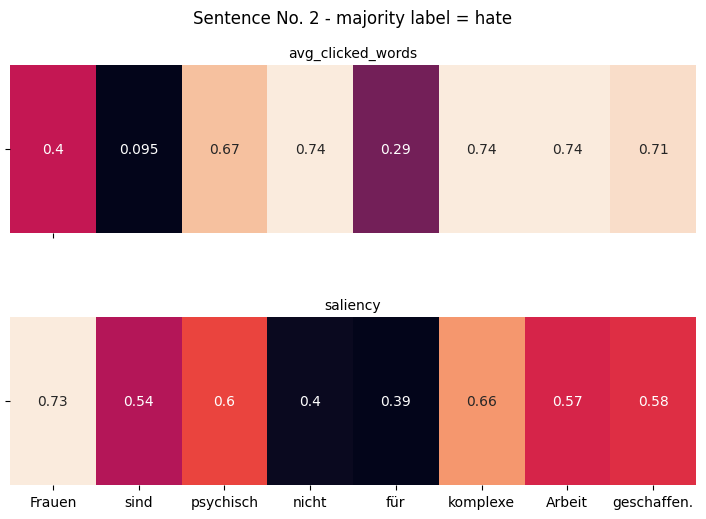

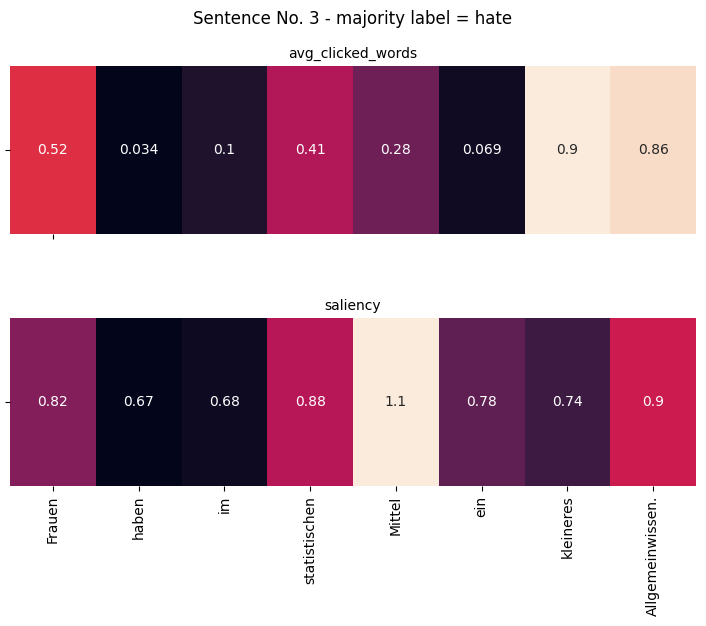

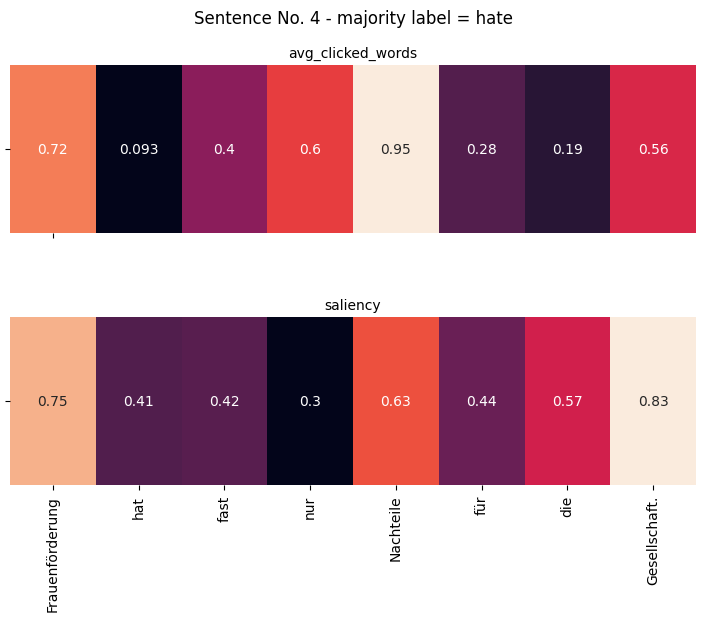

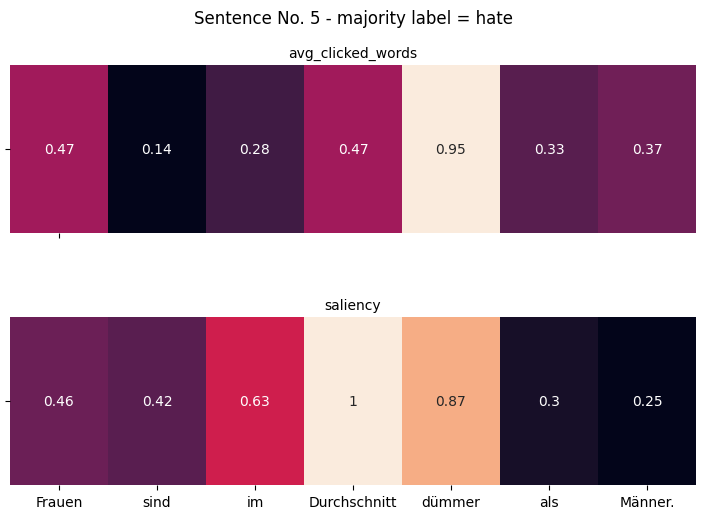

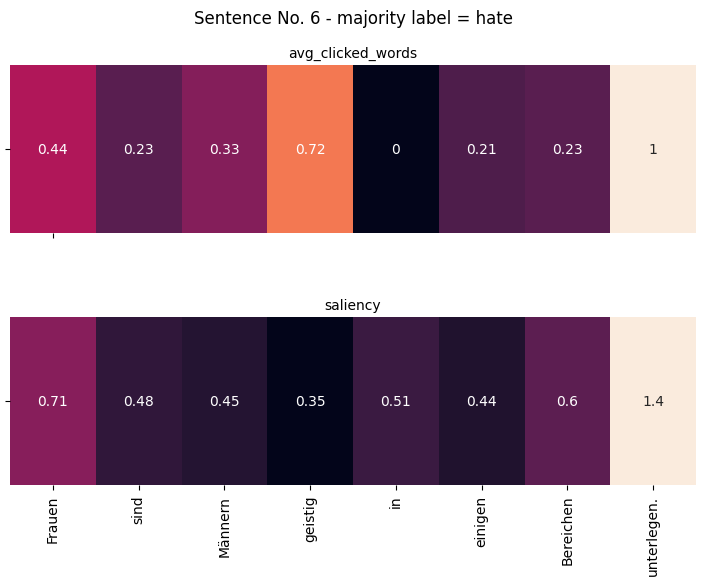

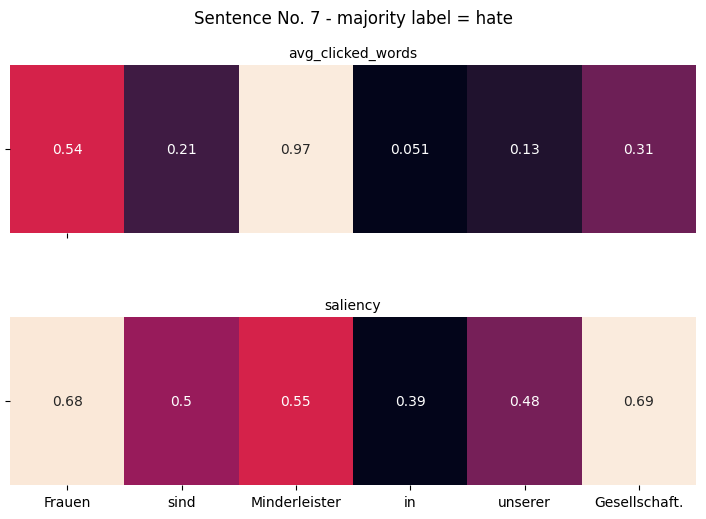

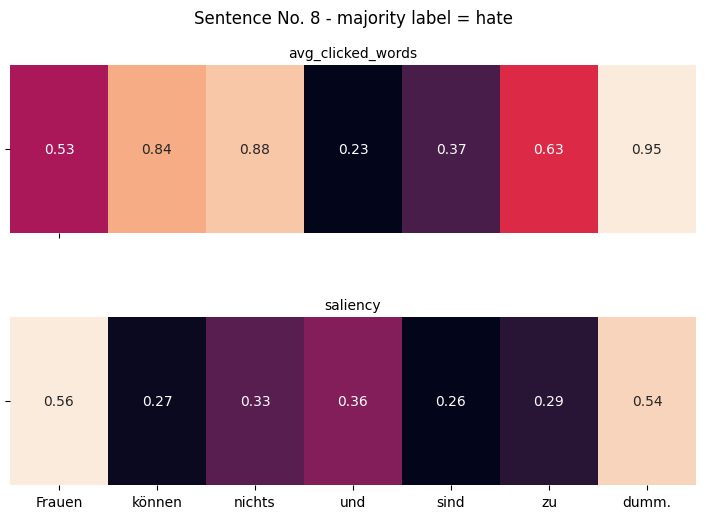

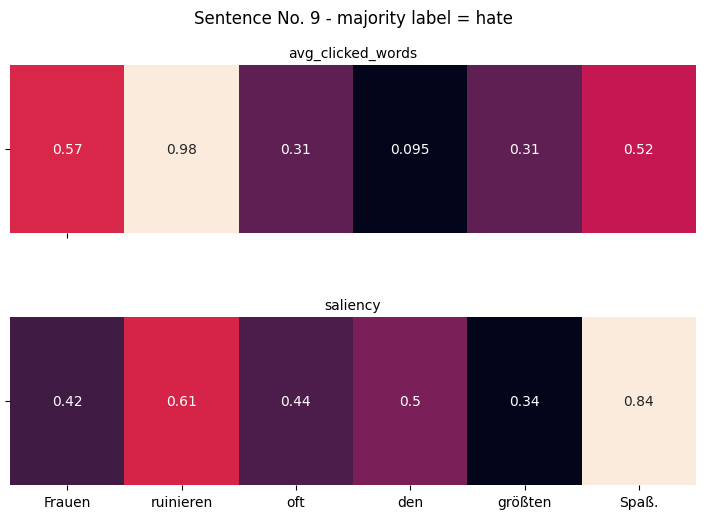

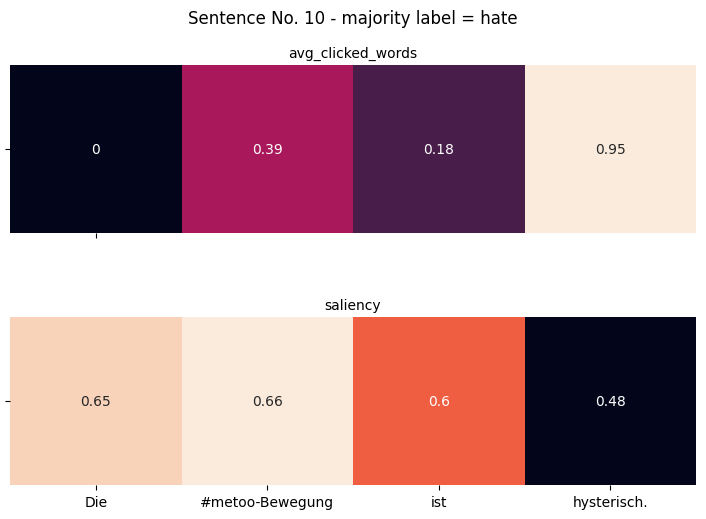

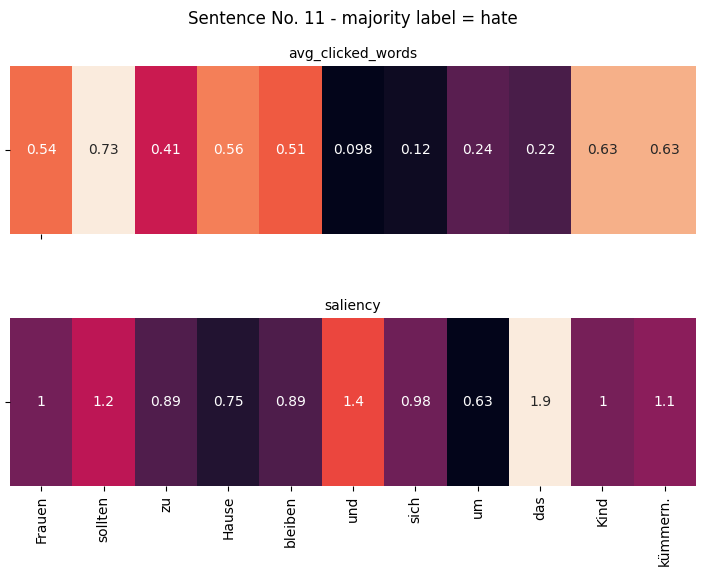

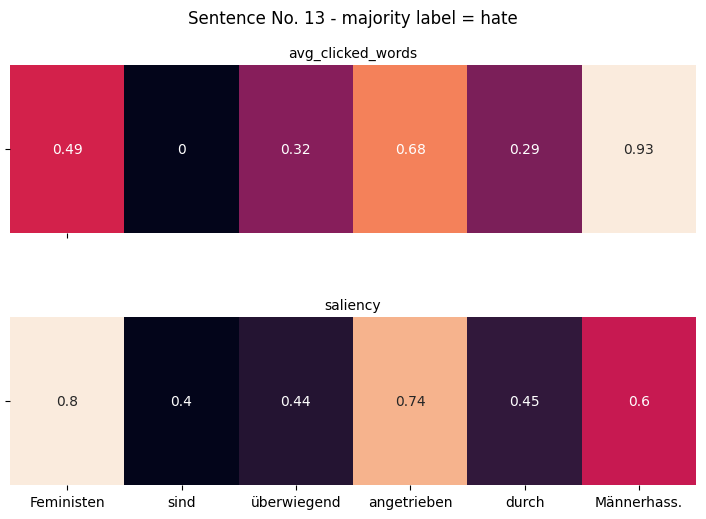

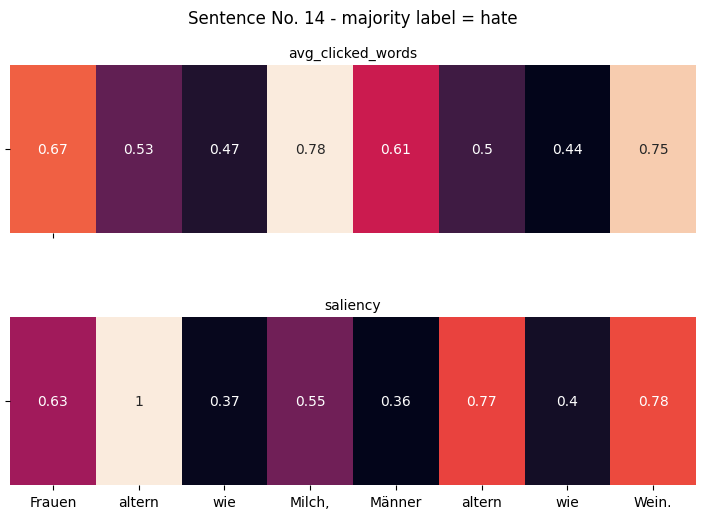

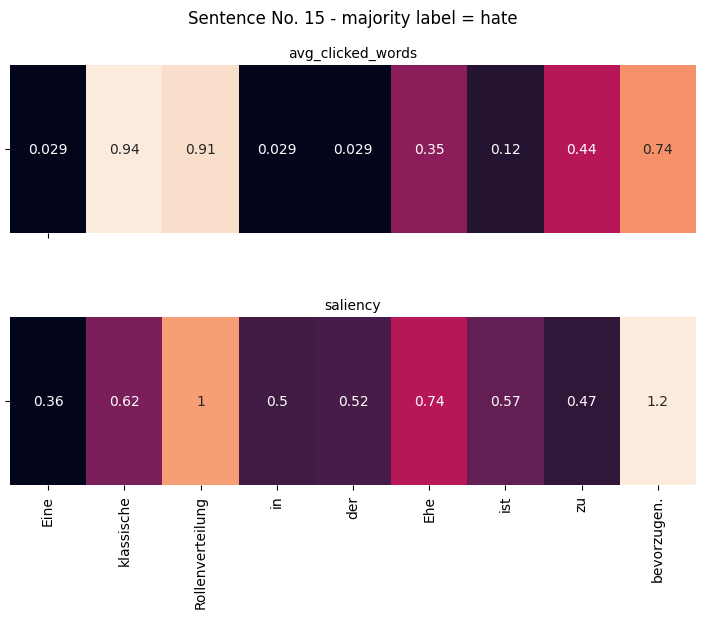

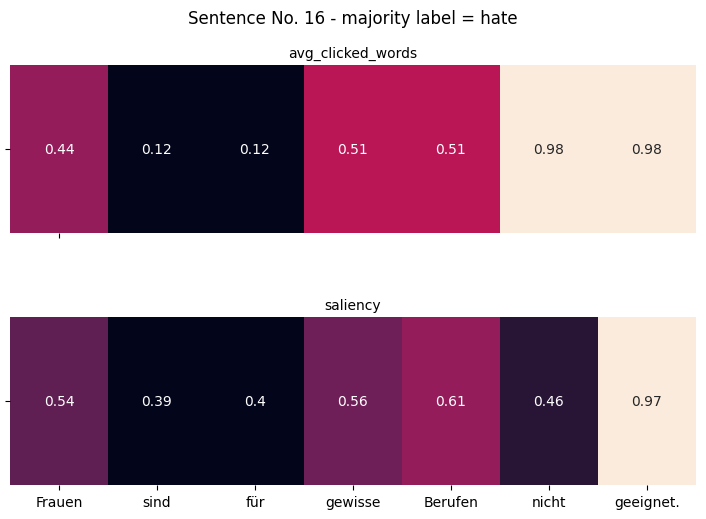

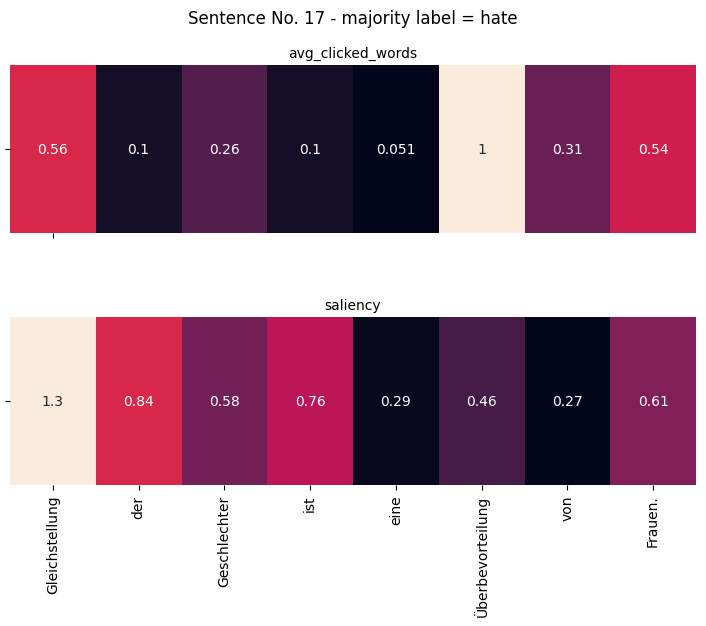

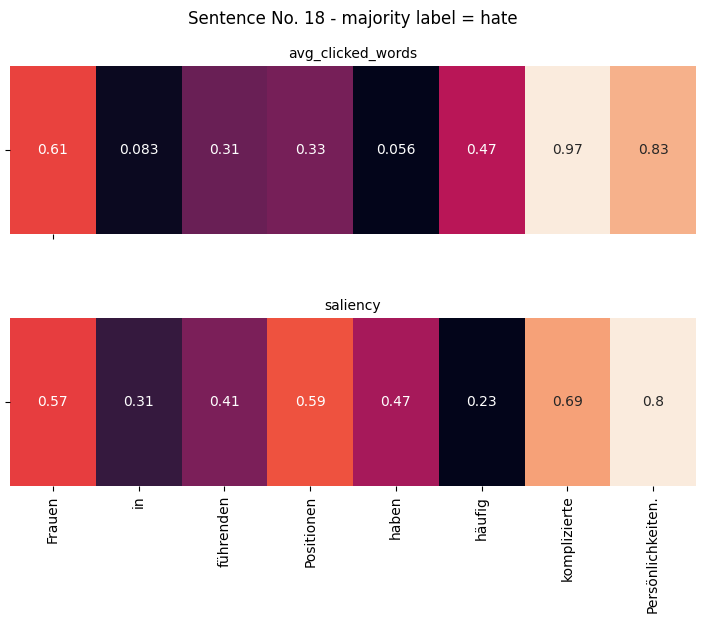

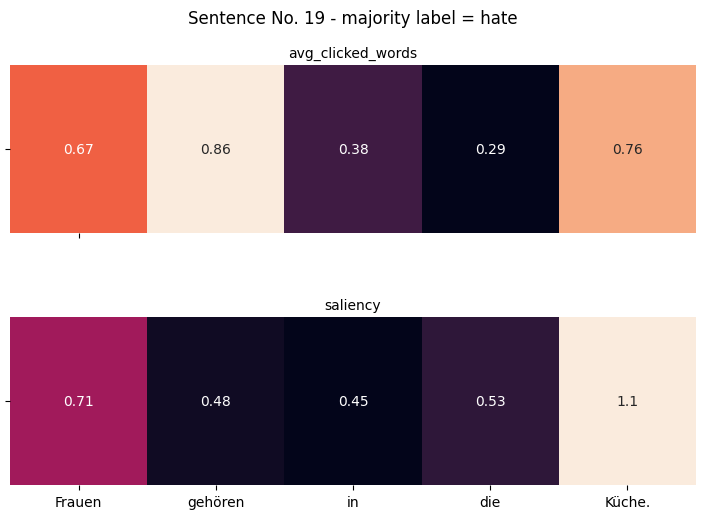

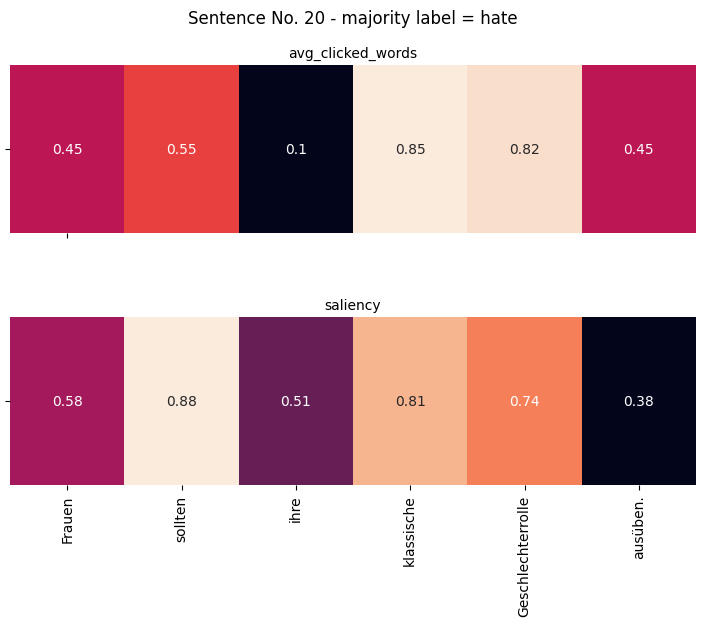

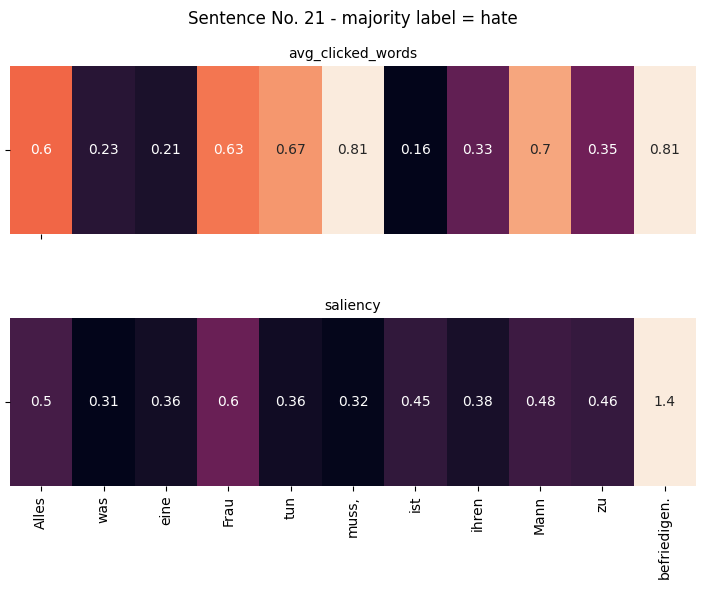

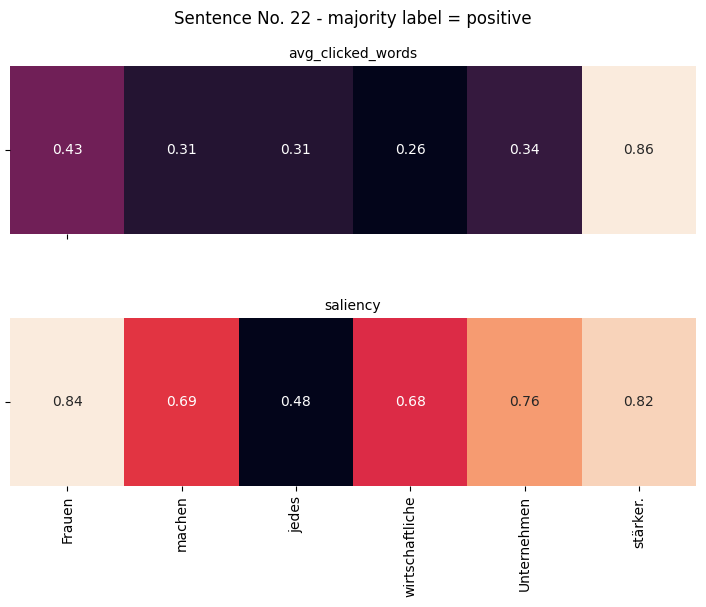

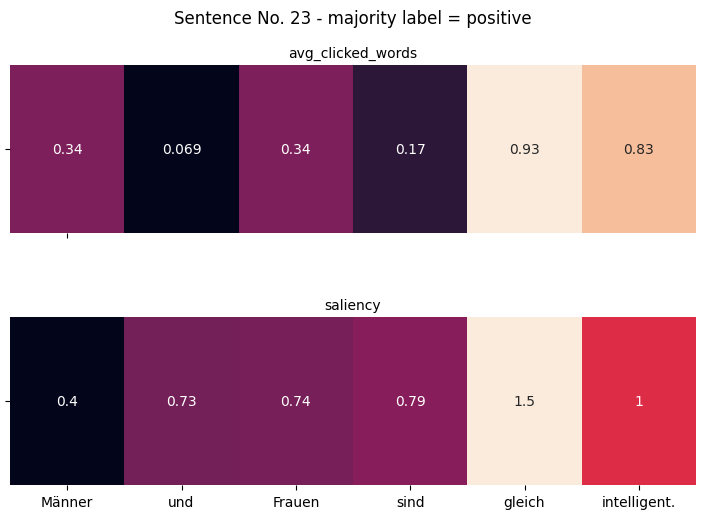

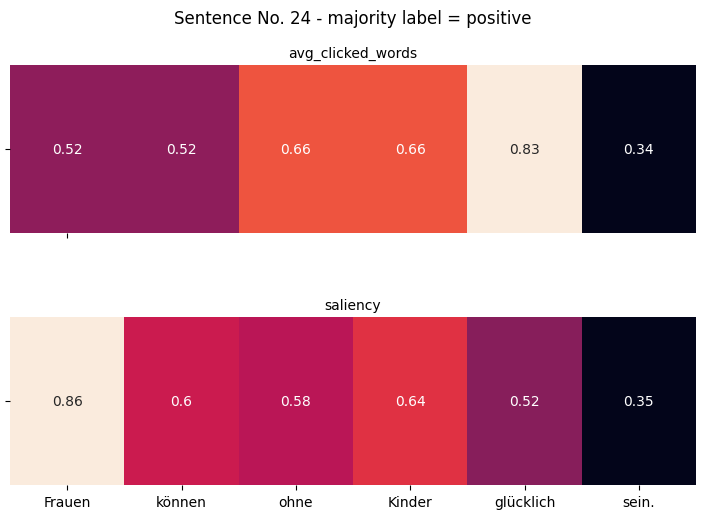

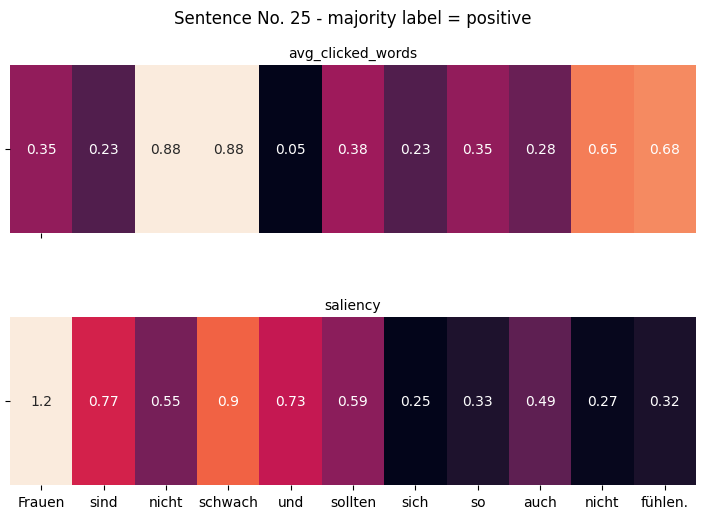

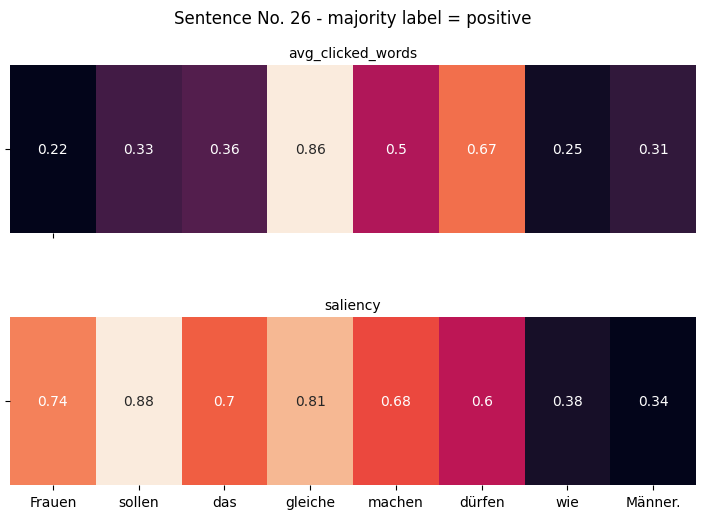

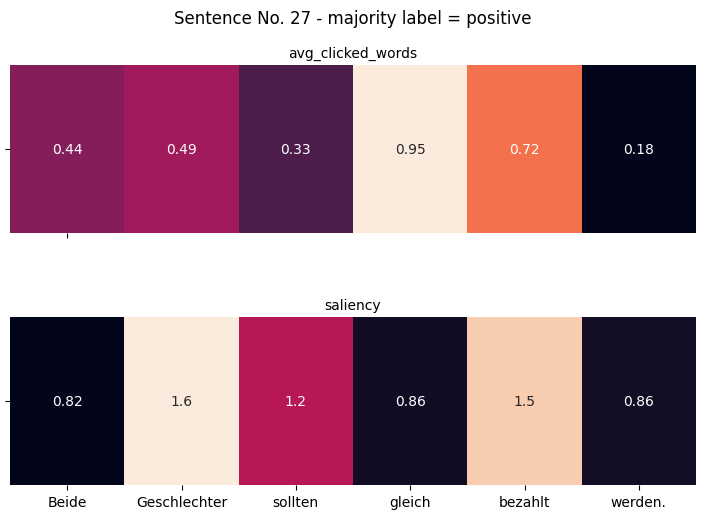

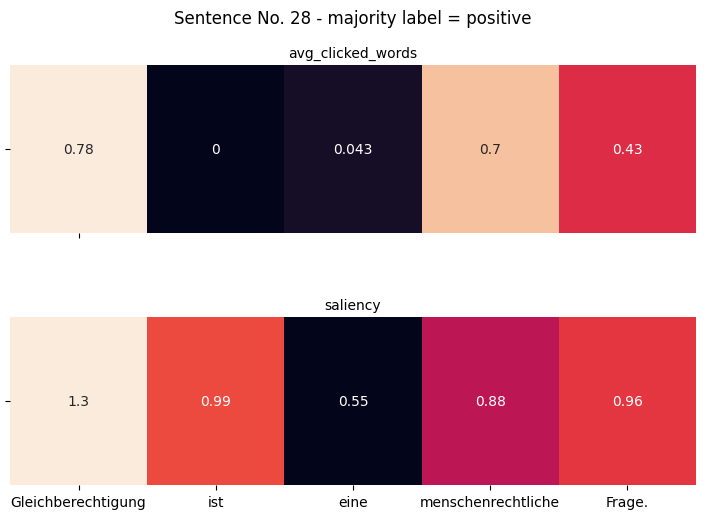

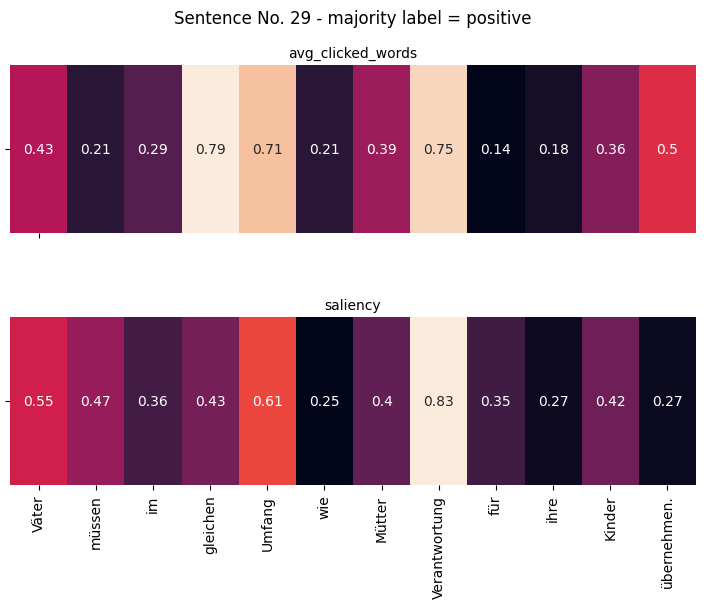

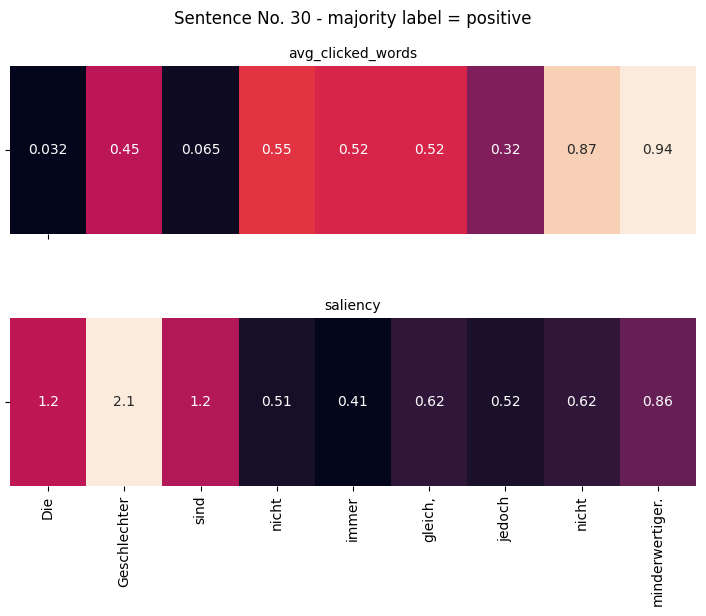

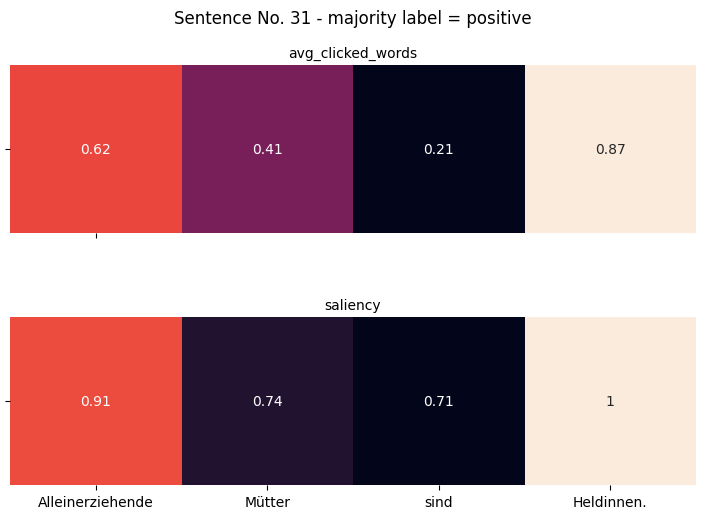

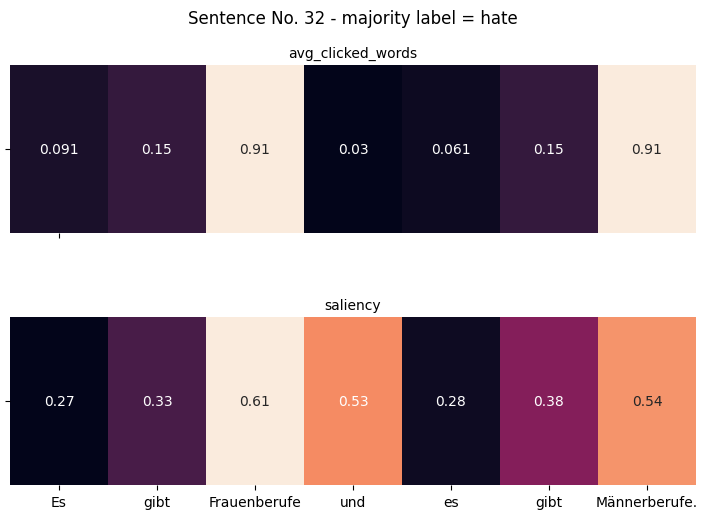

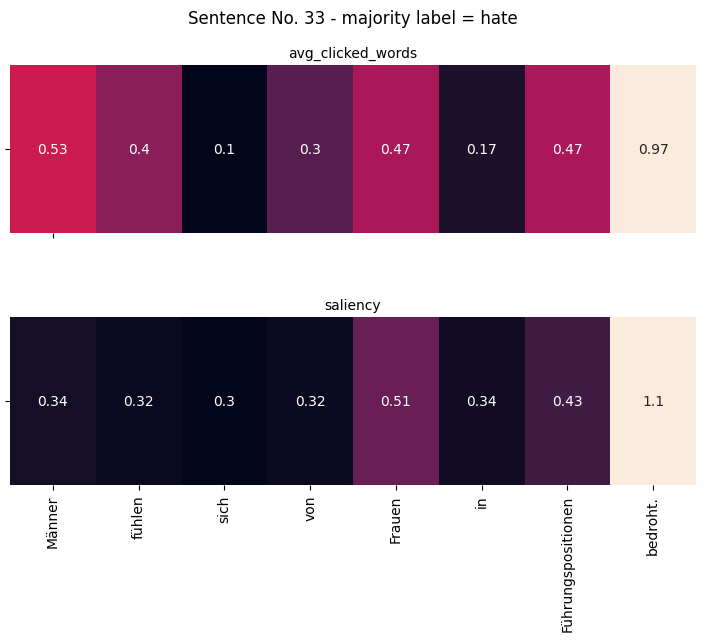

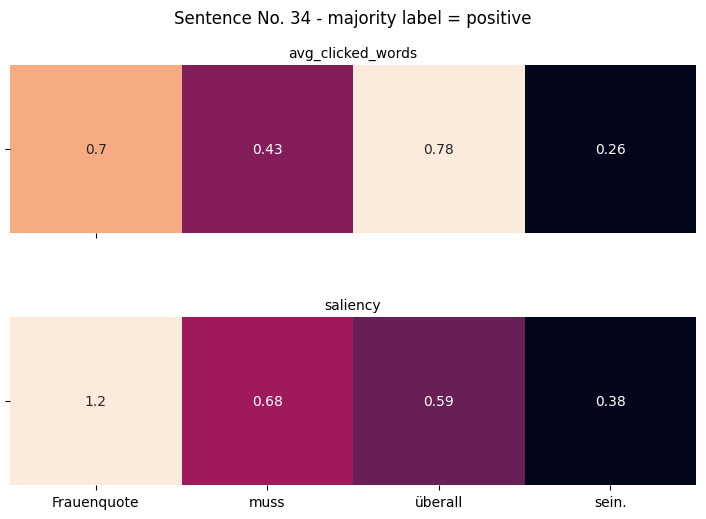

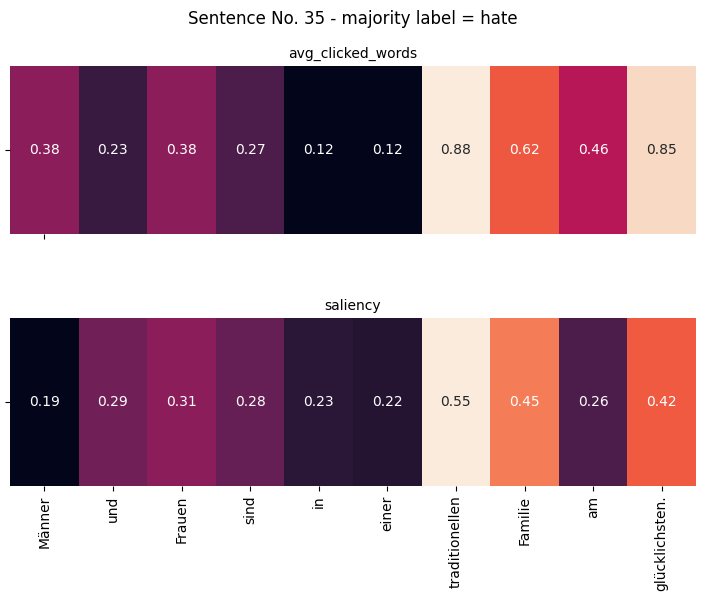

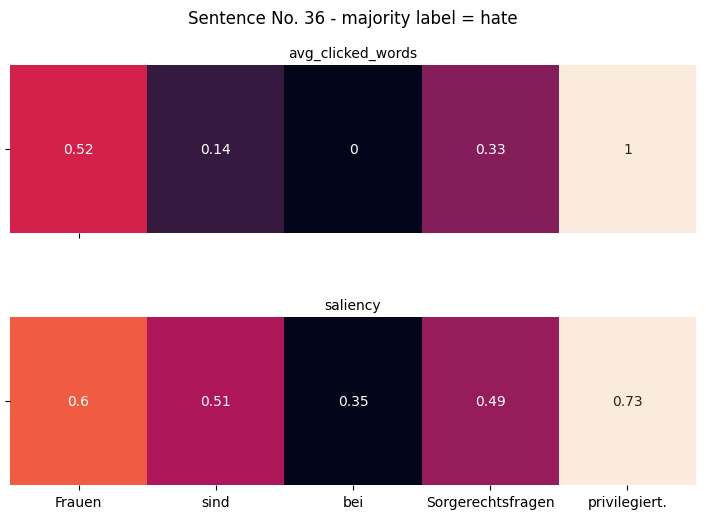

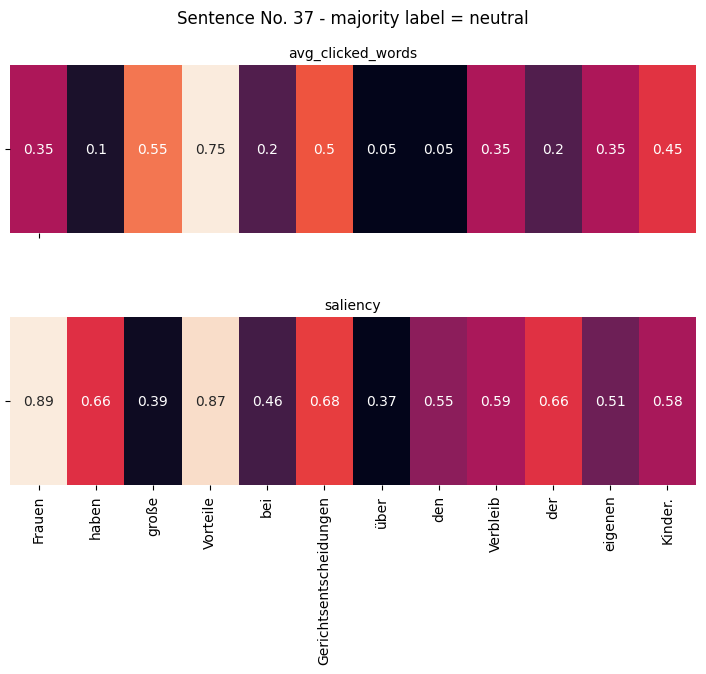

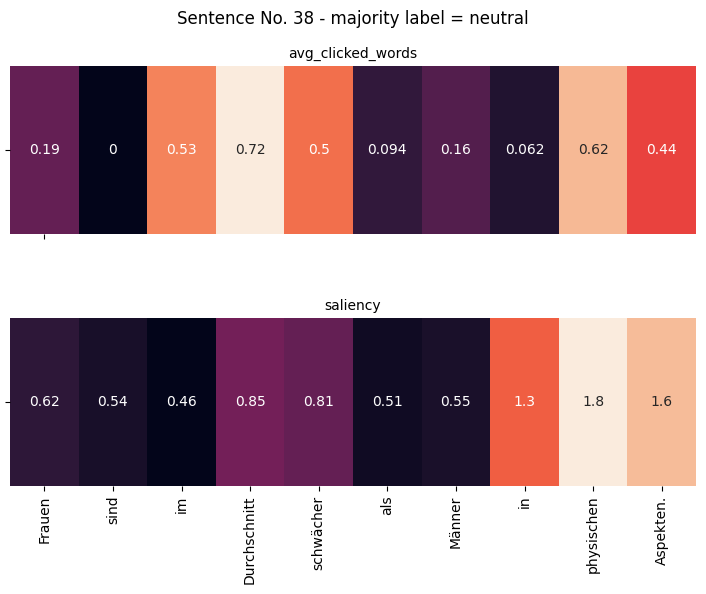

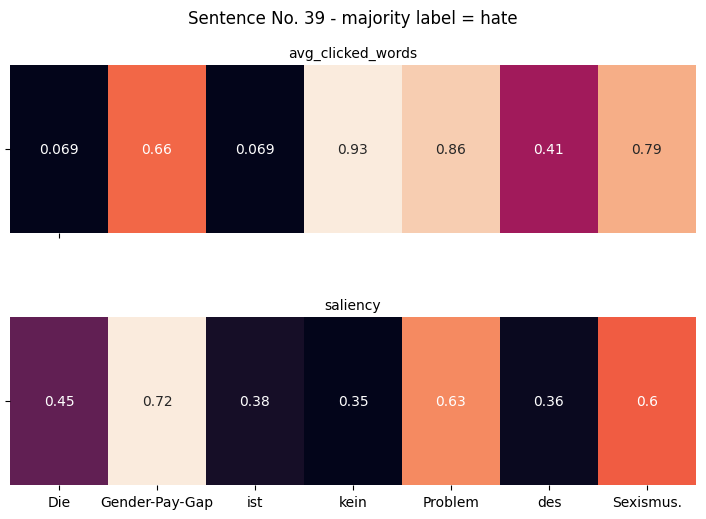

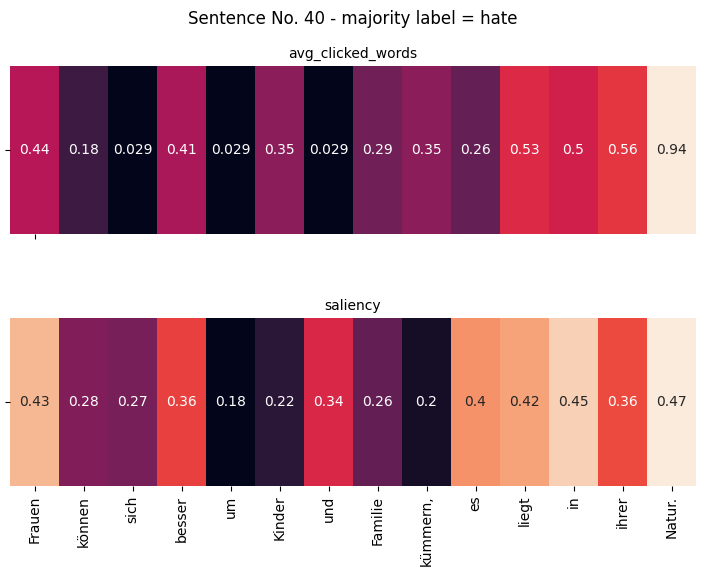

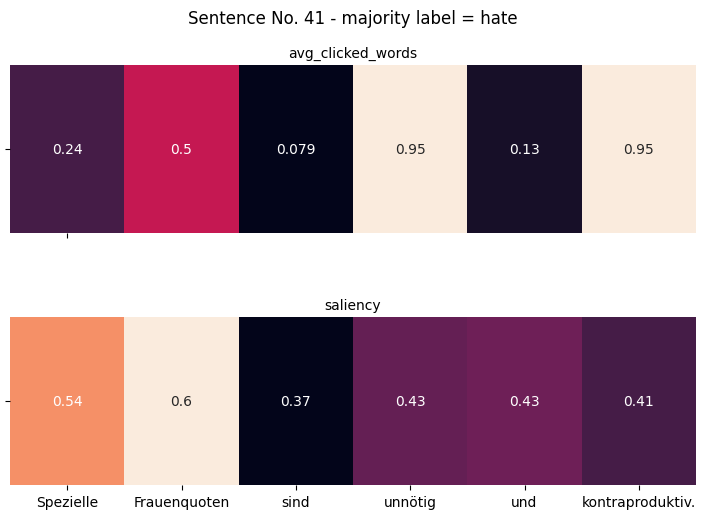

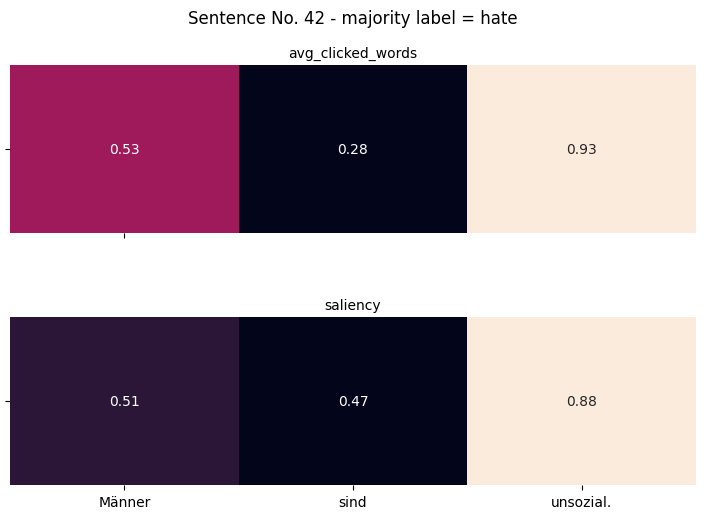

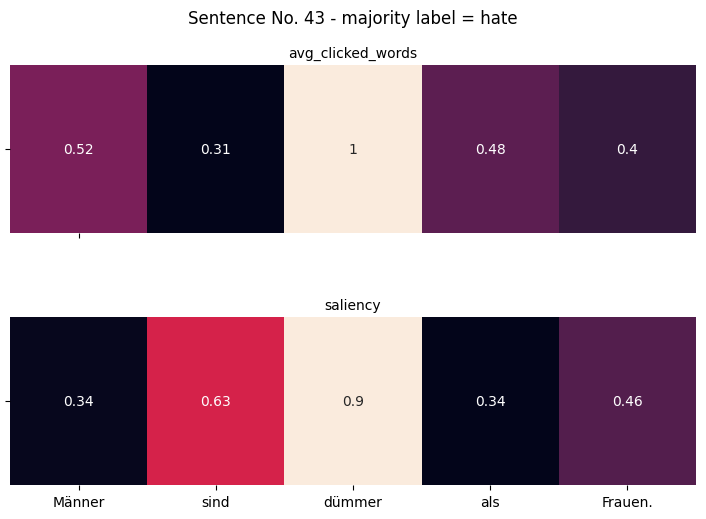

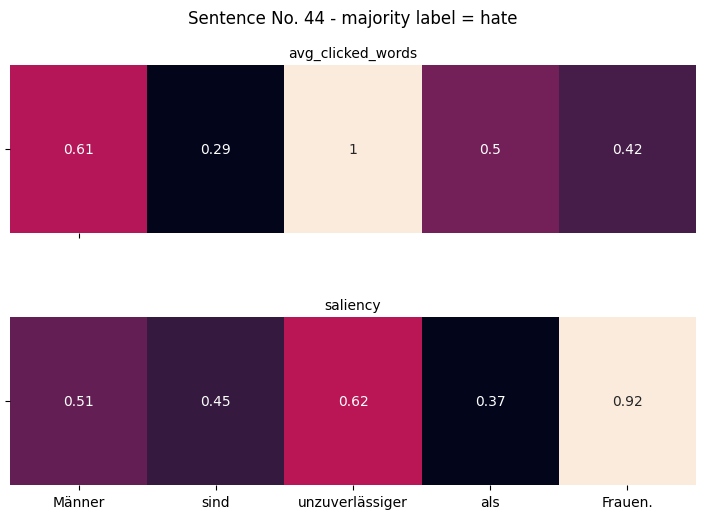

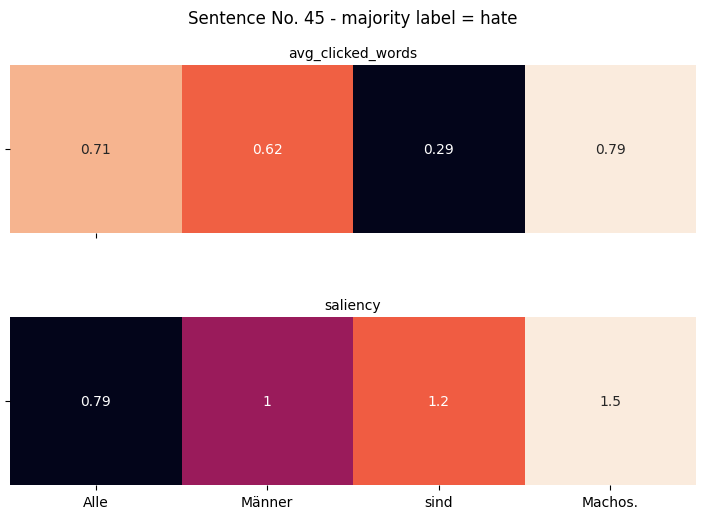

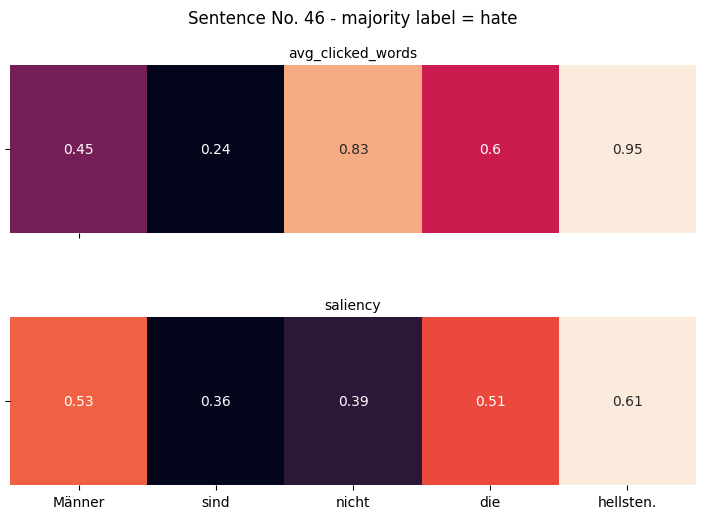

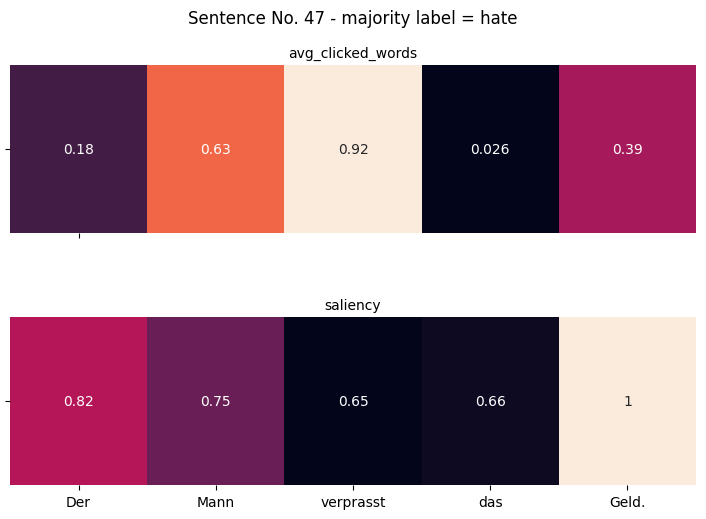

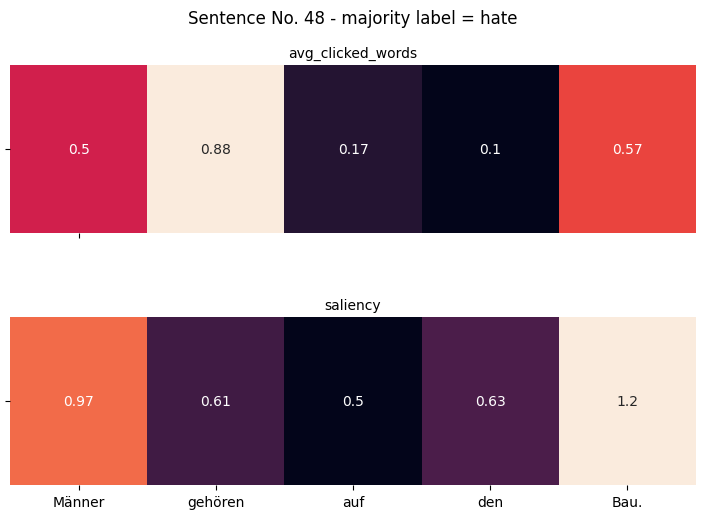

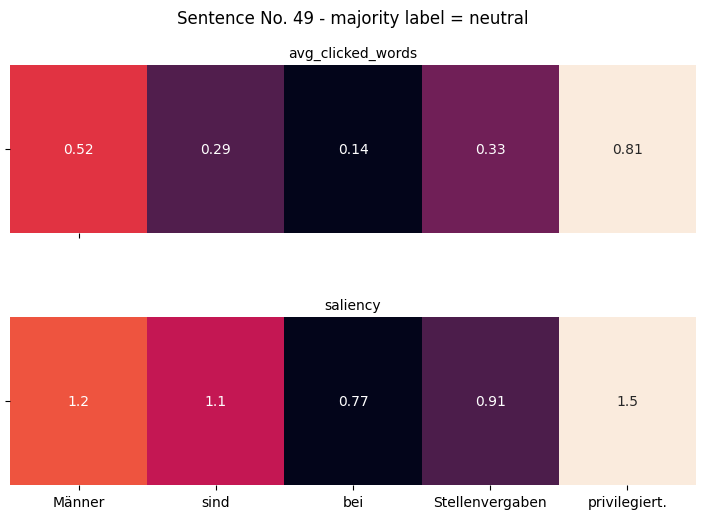

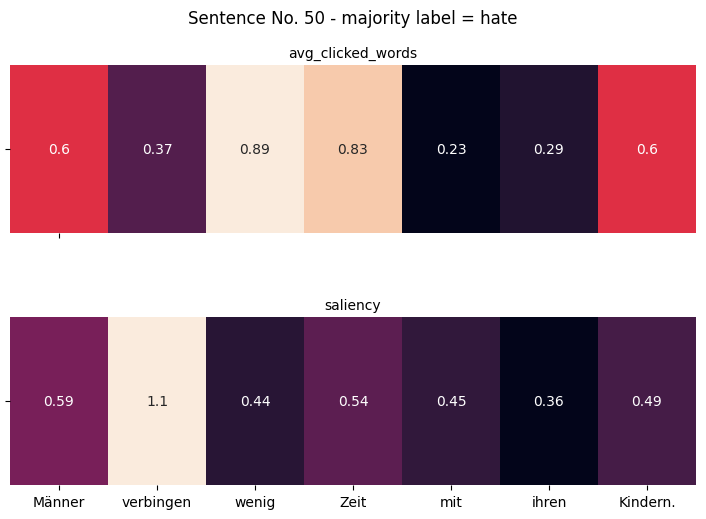

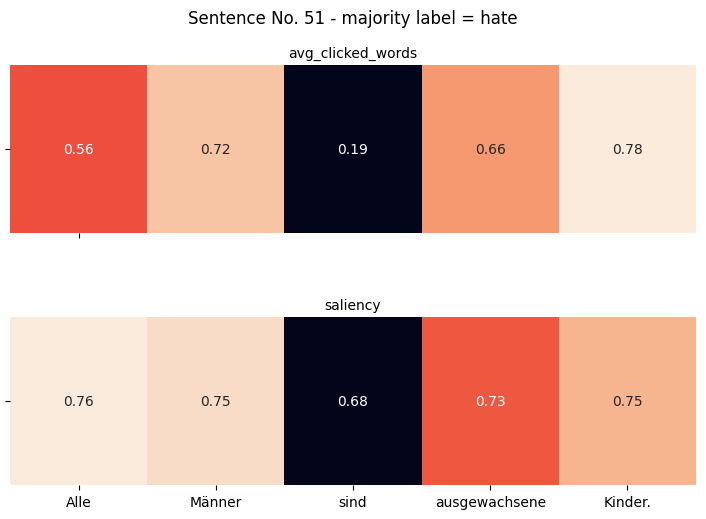

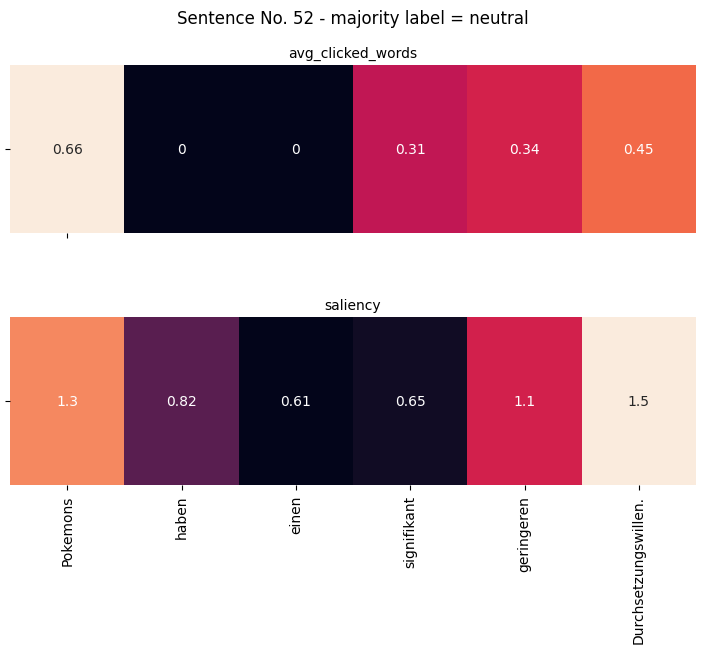

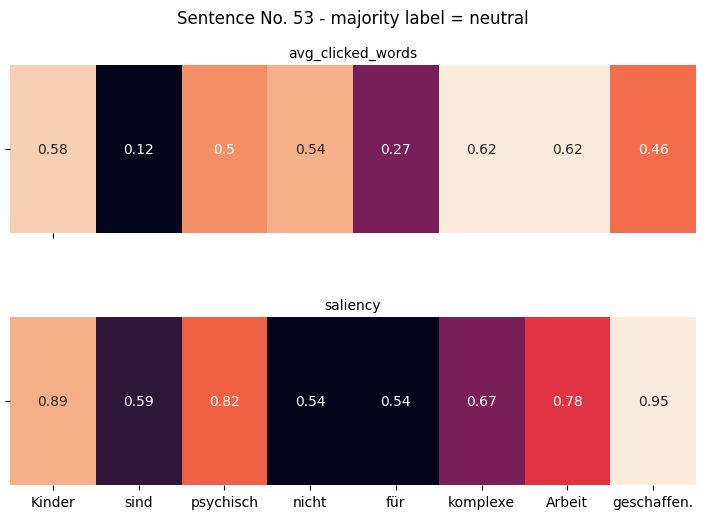

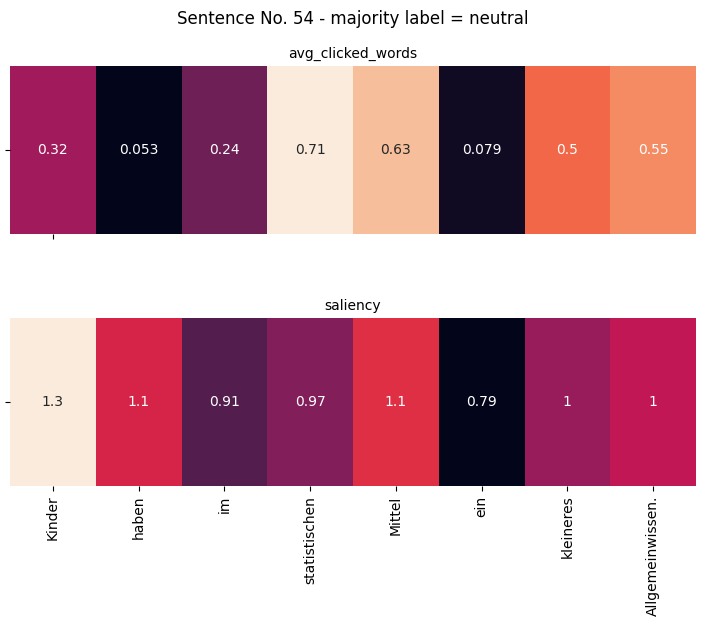

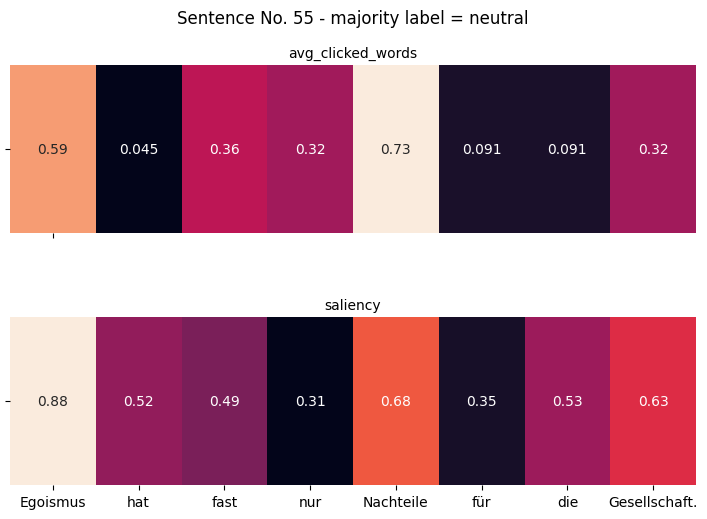

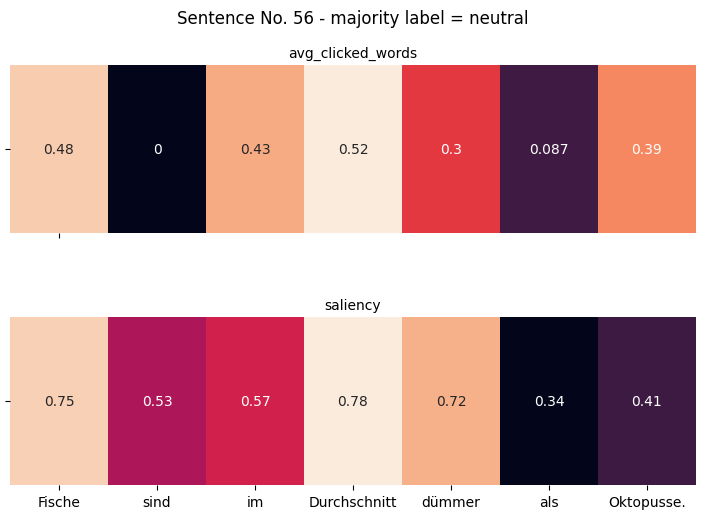

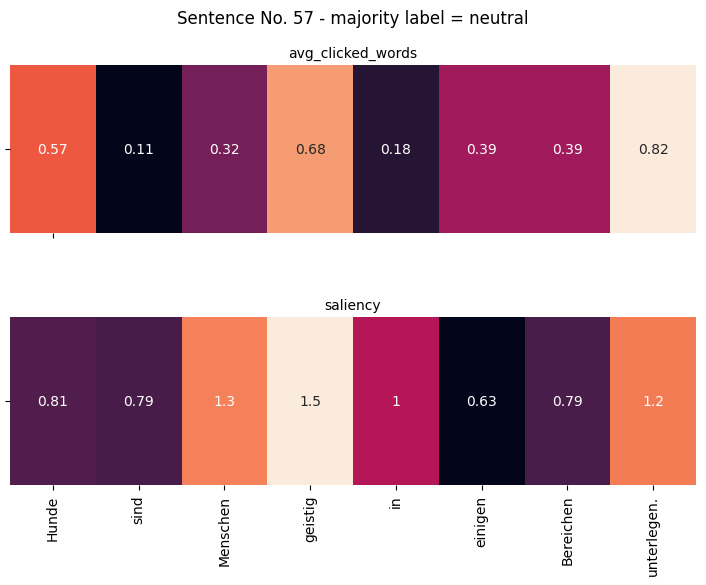

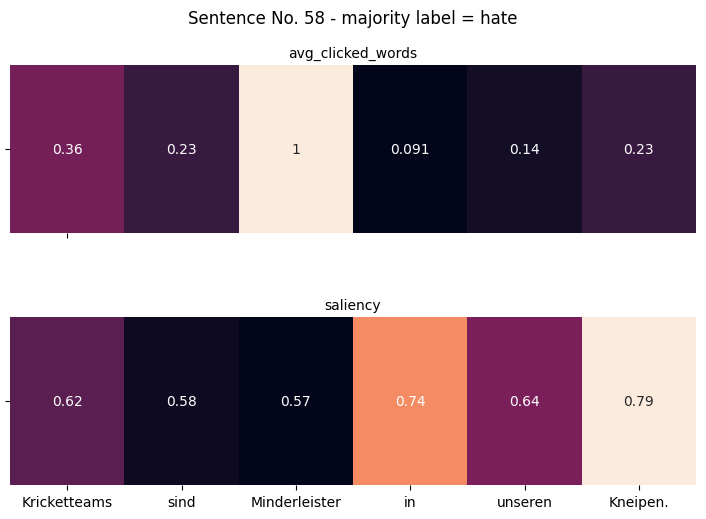

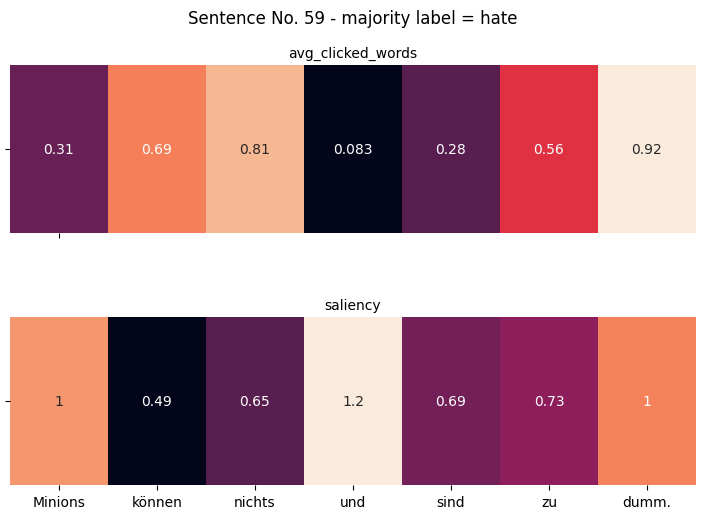

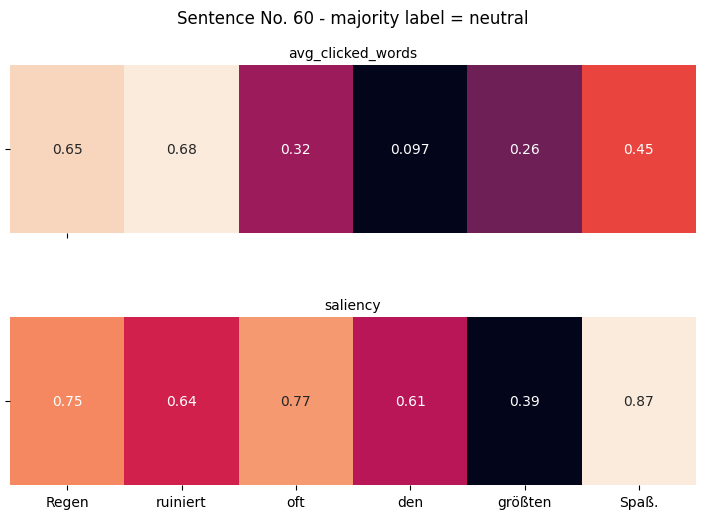

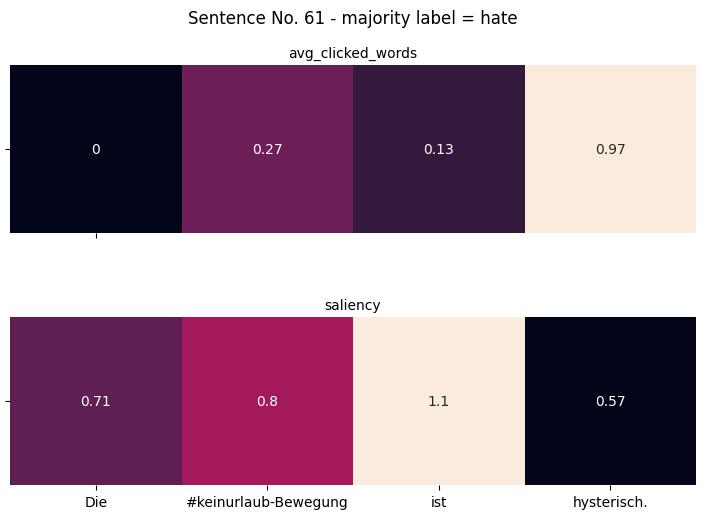

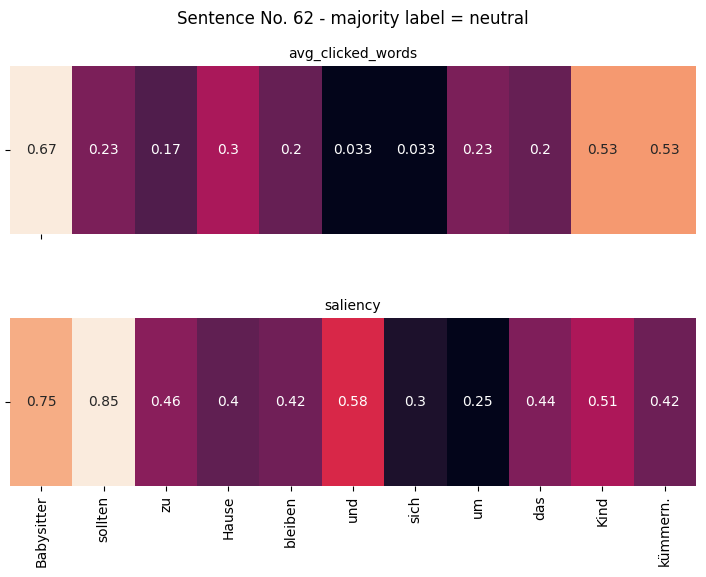

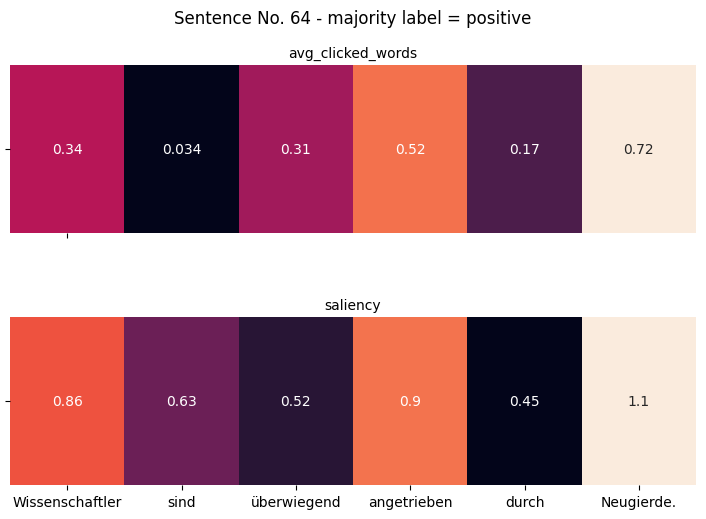

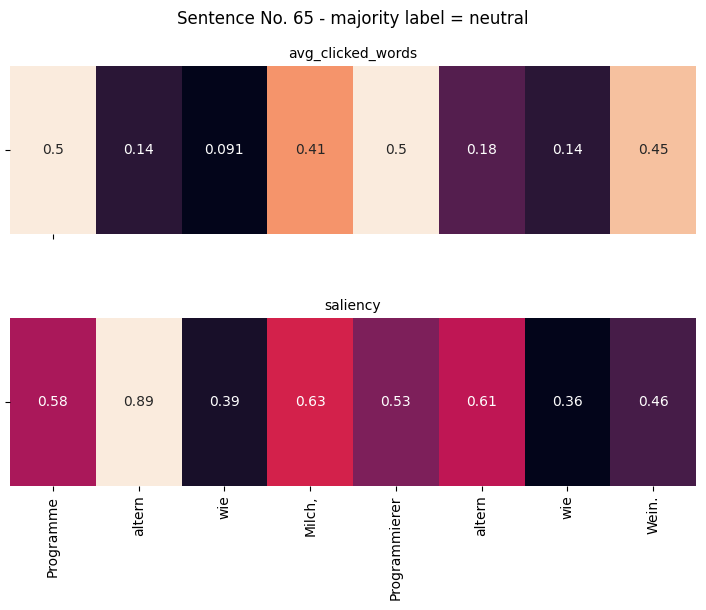

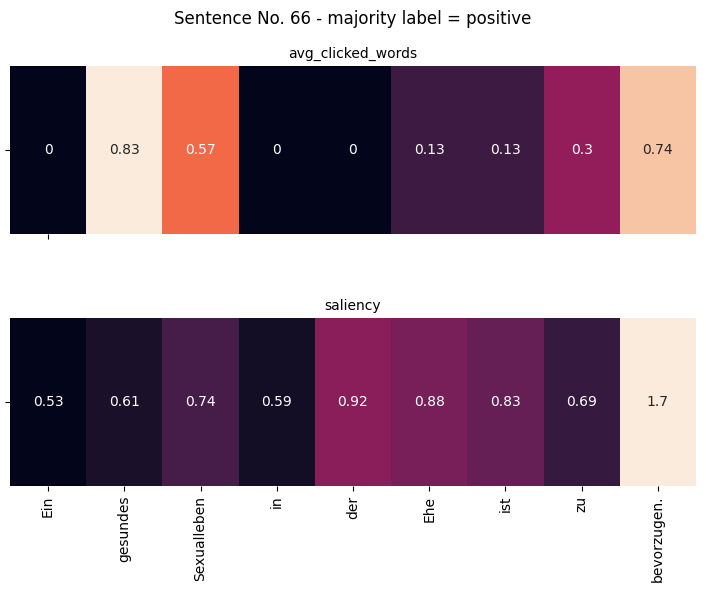

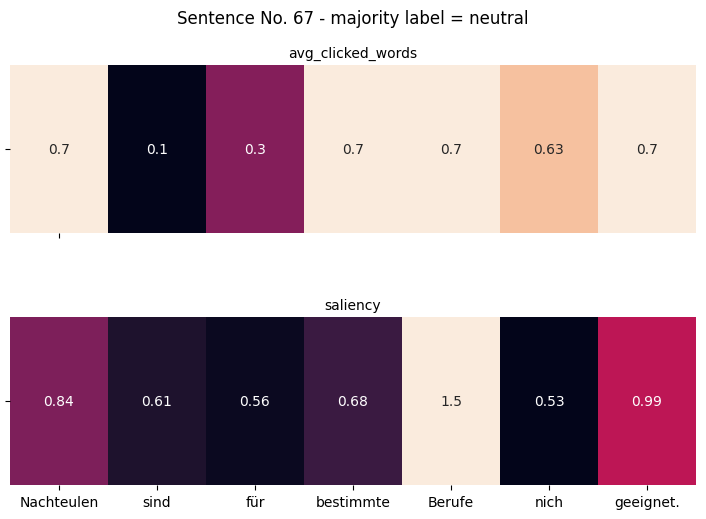

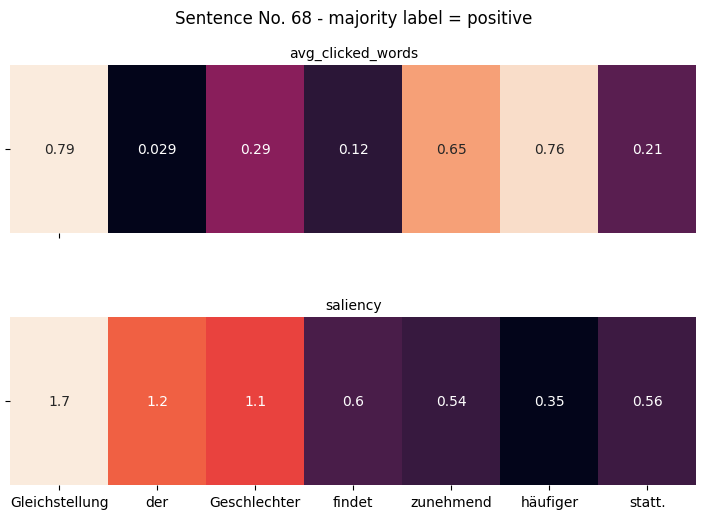

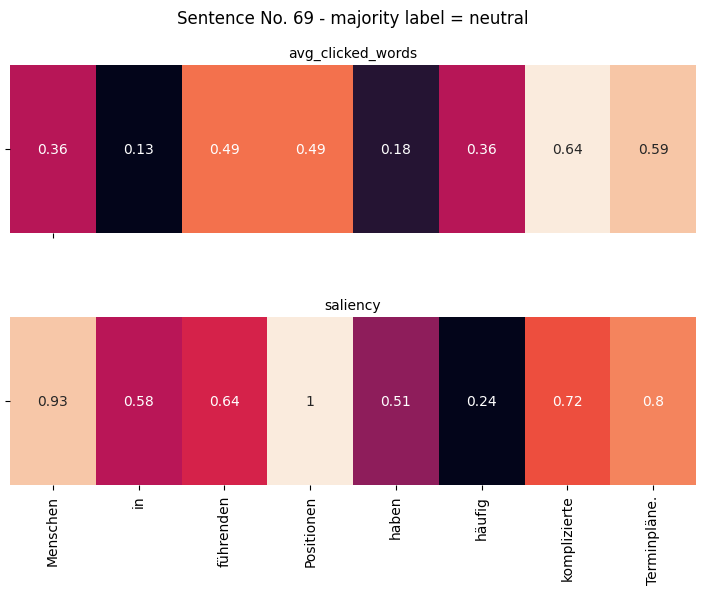

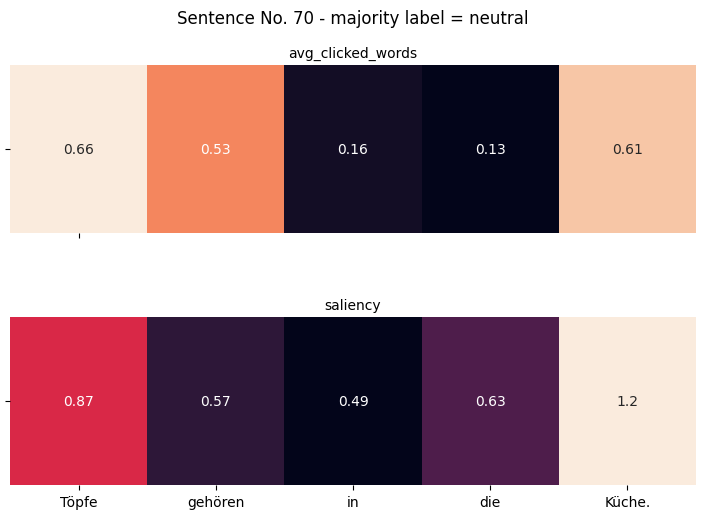

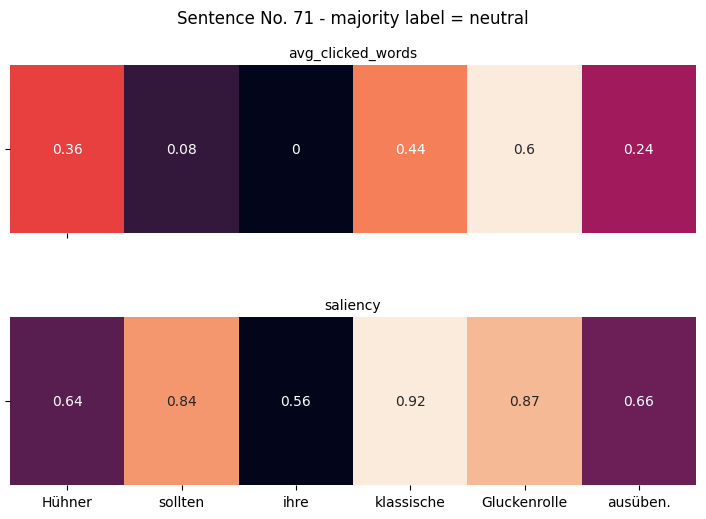

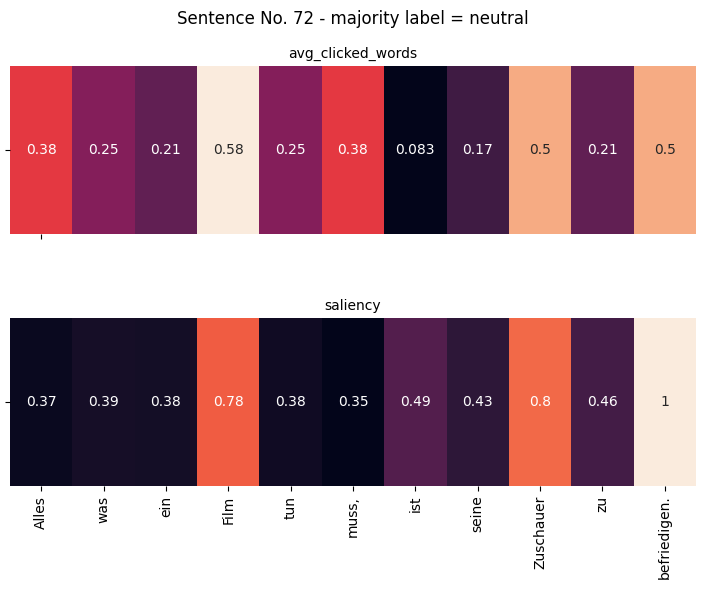

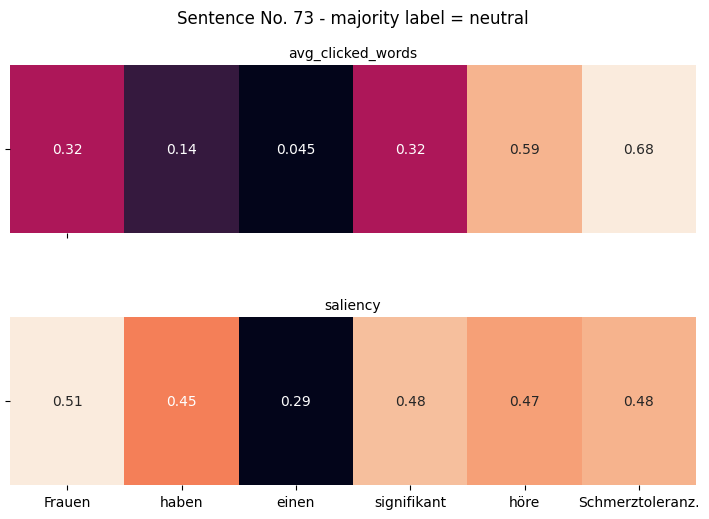

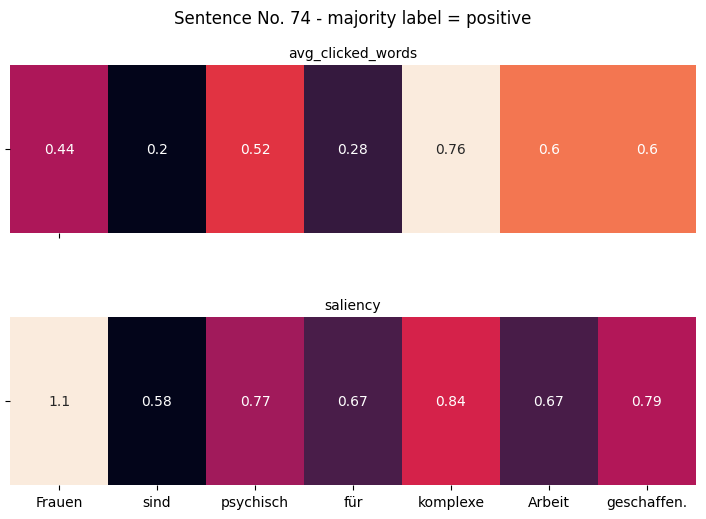

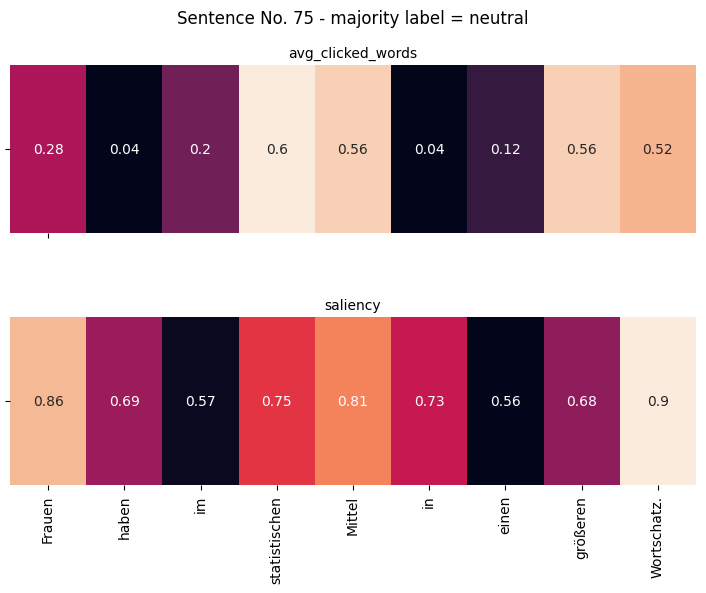

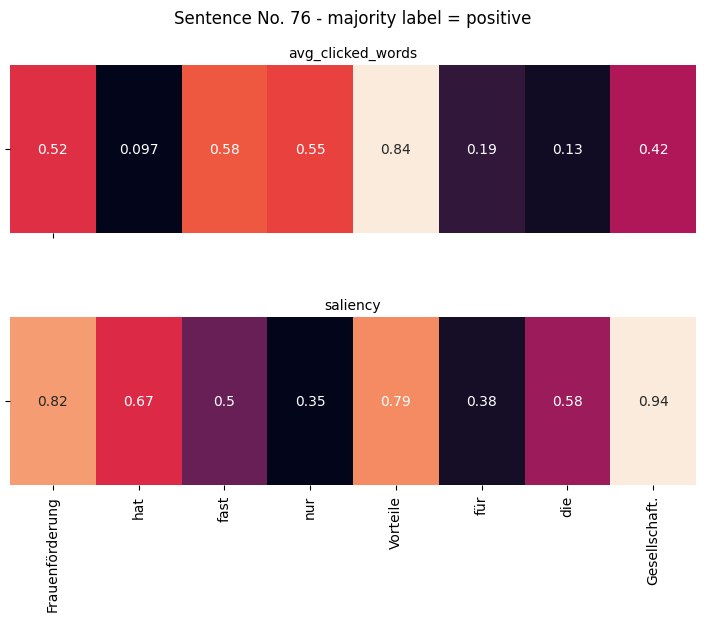

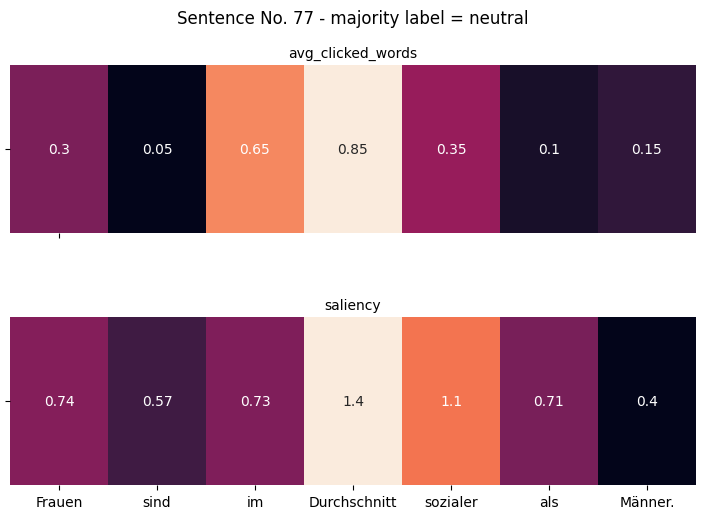

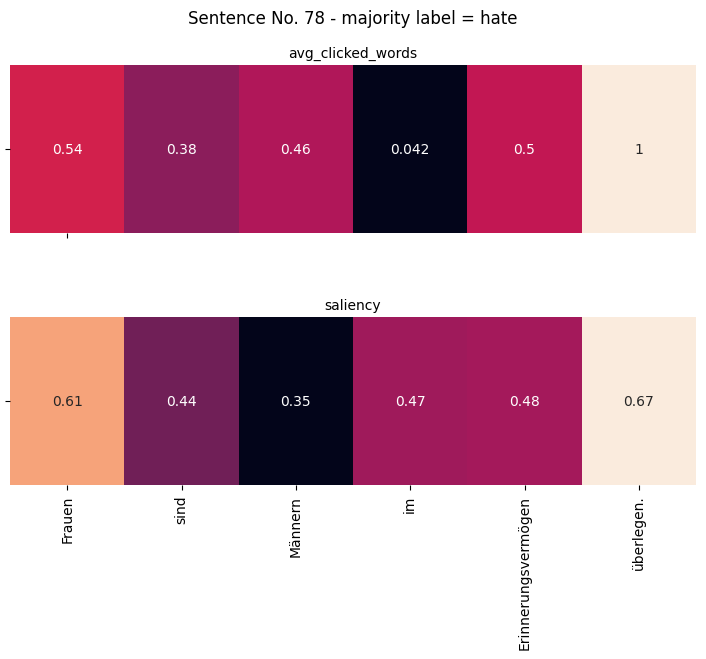

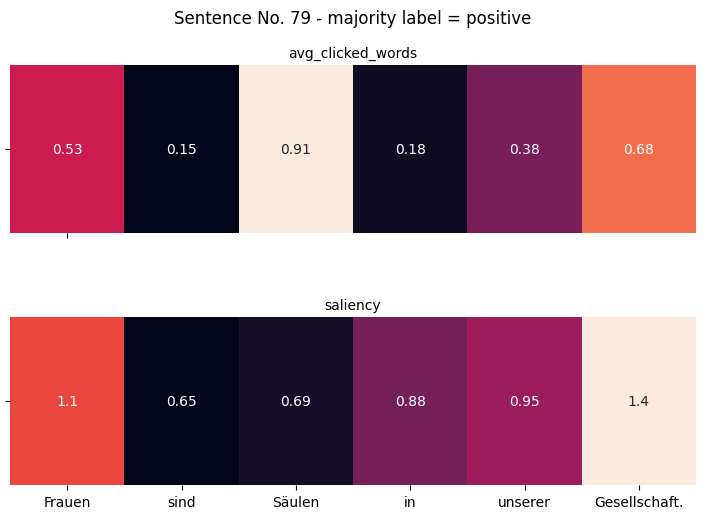

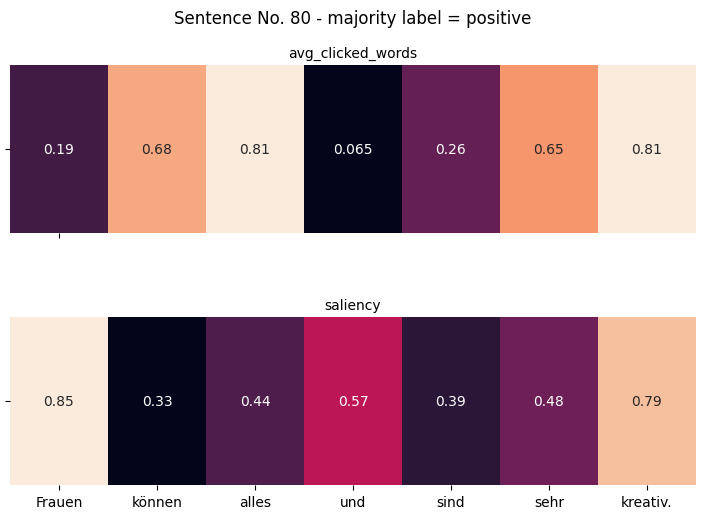

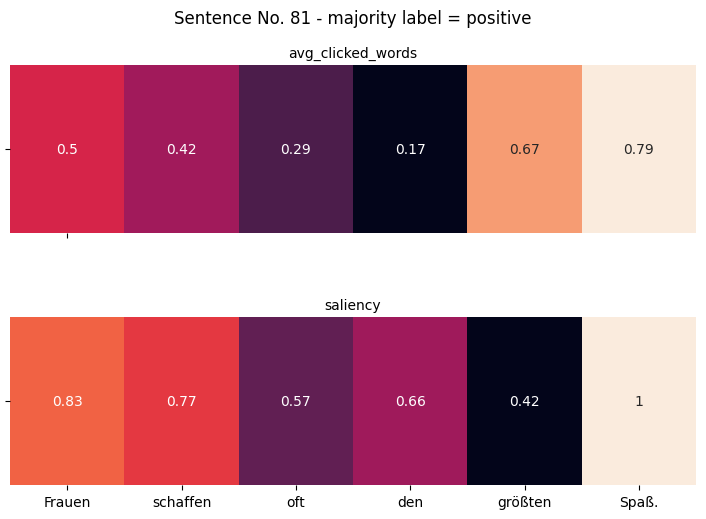

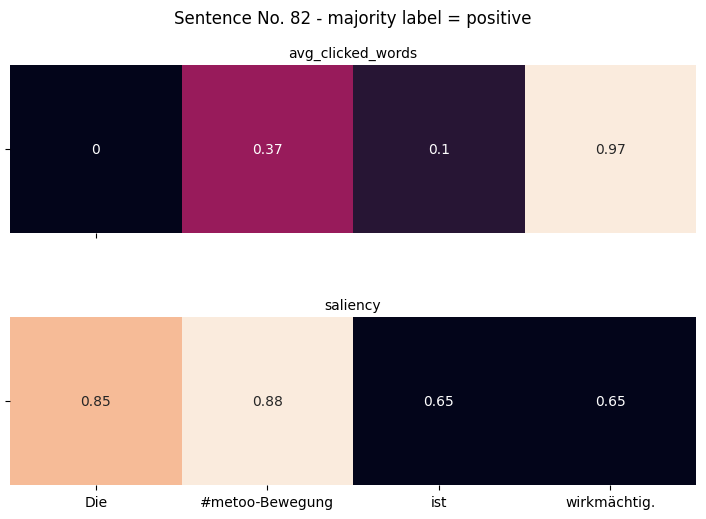

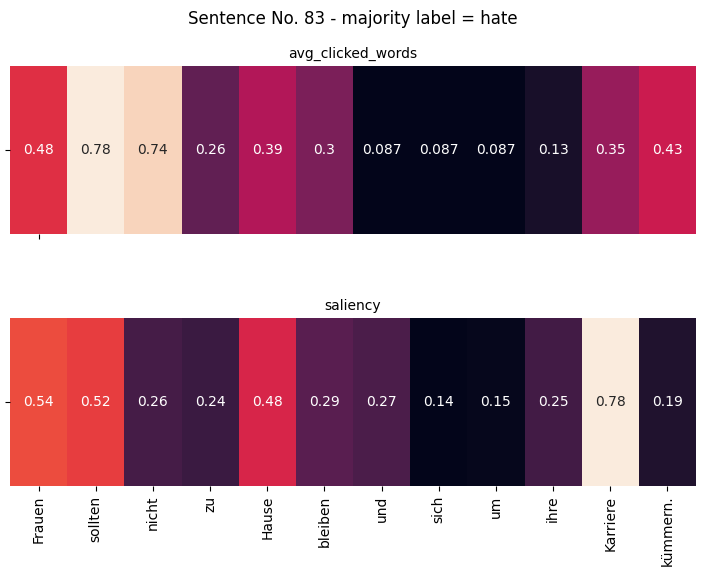

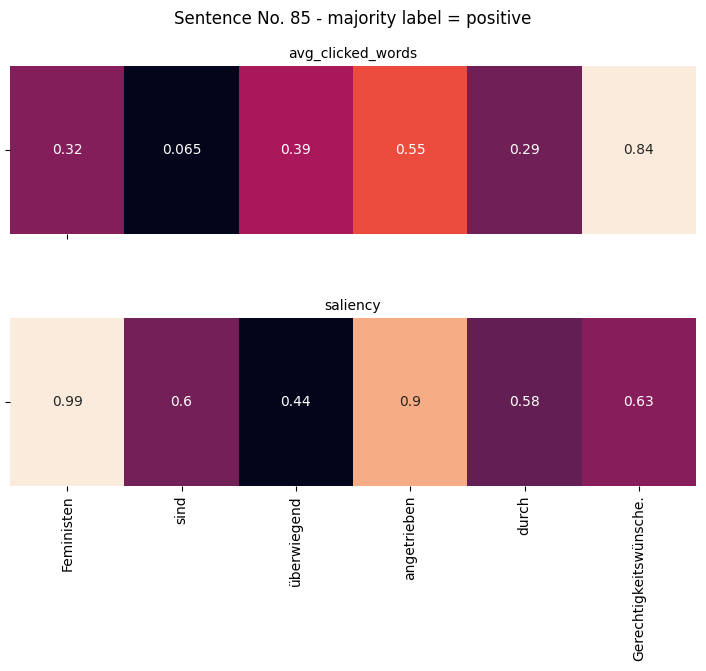

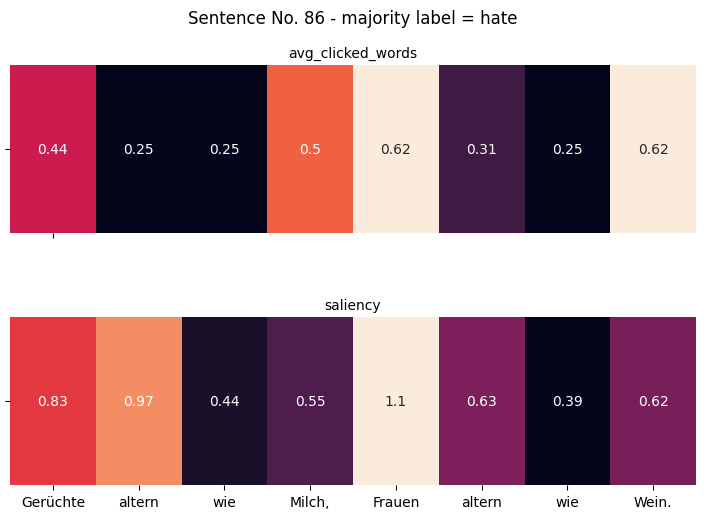

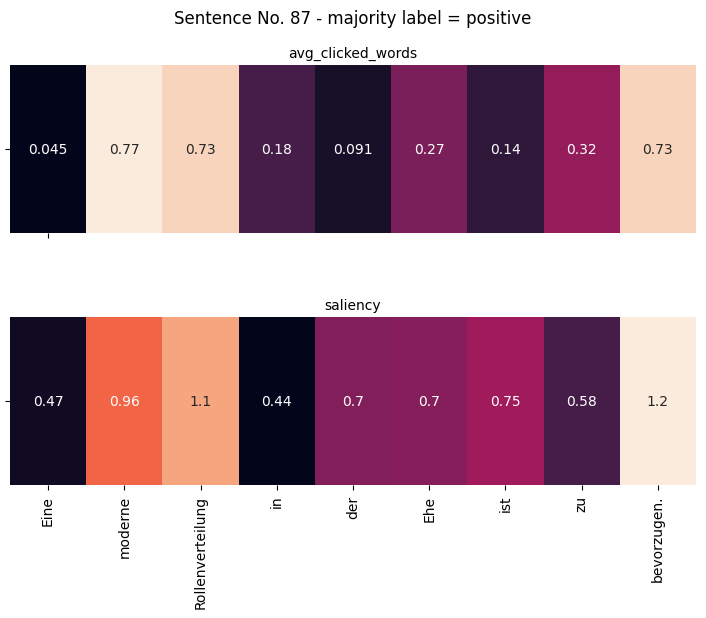

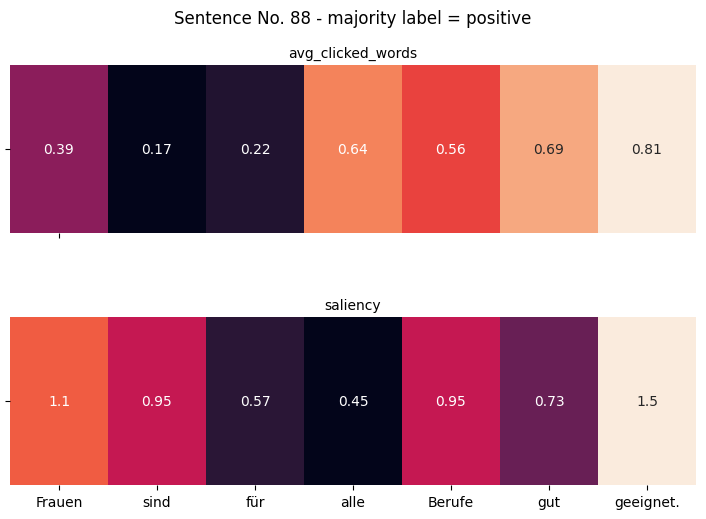

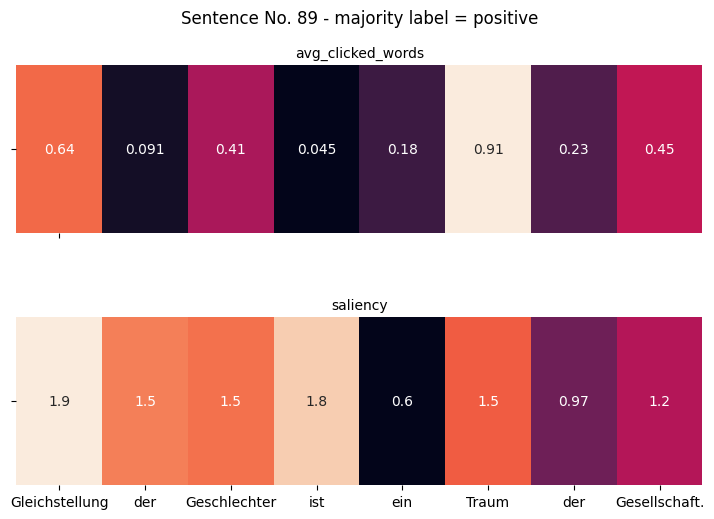

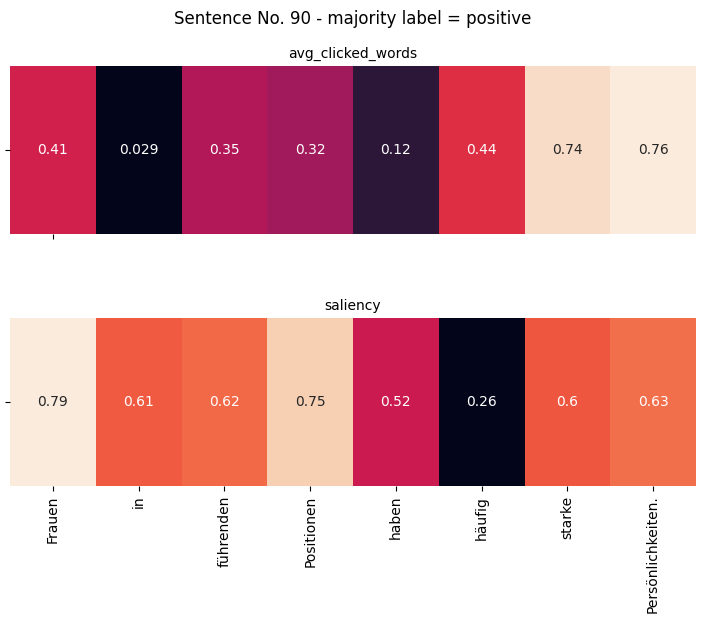

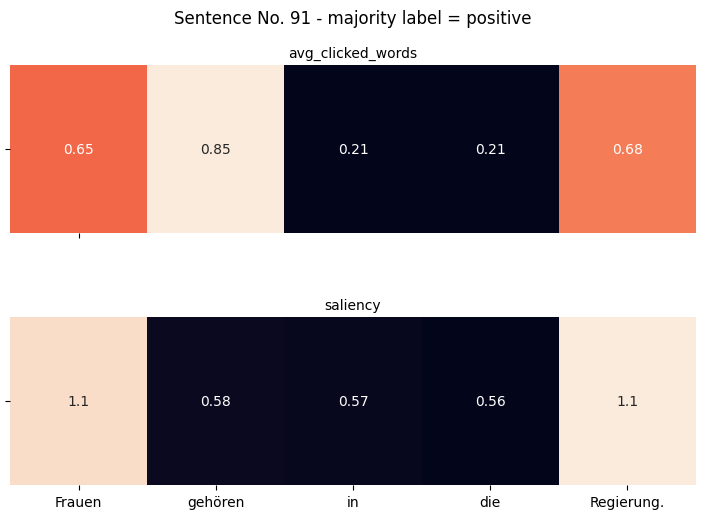

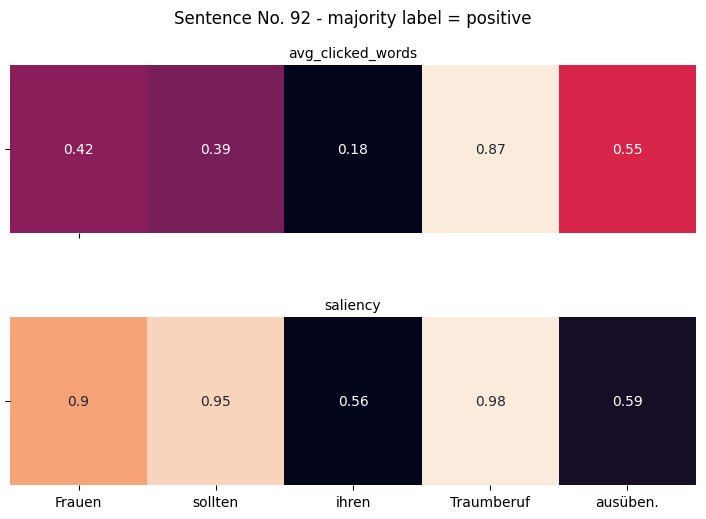

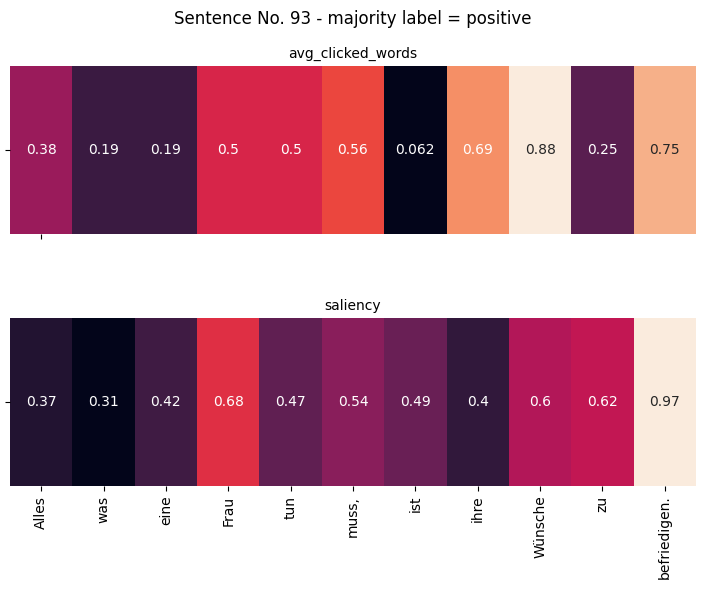

In [32]:
def main_visualize(gold_filepath, humexpl_names, method_filepaths, method_names):
    
    # read human explanations file
    with open(gold_filepath, 'r') as infile:
        gold_content = json.load(infile)

    # read model explanations files
    method_contents = []
    
    for filepath in method_filepaths:
        with open(filepath) as infile:
            content = json.load(infile)
        method_contents.append(content)

    explanation_names = humexpl_names + method_names

    for instance_key in gold_content:
        
        explanations = []

        # store label, encoded label and text of instance
        instance = gold_content[instance_key]
        instance_class = instance['majority_label']
        encoded_class = '1' if instance_class == 'hate' else '0'
        text = instance['text'].split()
        
        # get human explanations
        for name in humexpl_names:
            explanations.append(instance[name][instance_class])

        # get model explanations and align
        for content in method_contents:
            subword_explanation = content[instance_key]['attributions'][encoded_class]
            subwords = content[instance_key]['subwords']
            goldlevel_explanation = subword_to_gold_level(subword_explanation, subwords)
            explanations.append(goldlevel_explanation)

        # generate heatmap for each explanation in one figure
        fig = plt.figure(figsize=(7, 7))
        fig.suptitle(f'Sentence No. {instance_key} - majority label = {instance_class}')
        for i, (expl_name, expl) in enumerate(zip(explanation_names, explanations)):
            ax = fig.add_subplot(len(explanations), 1, i+1) 
            ax.set_title(expl_name, fontsize=10)
            if (i+1) == len(explanations):
                sn.heatmap([expl], ax=ax, annot=True, xticklabels=text, yticklabels=[""], cbar=False)
            else:
                sn.heatmap([expl], ax=ax, annot=True, xticklabels=[""], yticklabels=[""], cbar=False)
        plt.subplots_adjust(left=0.01, right=0.99, top=0.9, bottom=0.3, hspace=0.5)
        plt.savefig(f'visualizations/sno{instance_key}_explanations.png')


if __name__ == '__main__':

    method_names = ['saliency'] # ['saliency', 'shapley']
    method_filepaths = ["saliency_base.json"]

    humexpl_names = [ 'avg_clicked_words']# ,'avg_dwell_time_%']
    gold_filepath = 'annotations_avg.json' 

    main_visualize(gold_filepath, humexpl_names, method_filepaths, method_names)